# Parte 1: 

In [2]:
# === BIBLIOTECAS NECESS√ÅRIAS ===
# Manipula√ß√£o de dados e c√°lculos num√©ricos
import pandas as pd 
import numpy as np  
# Visualiza√ß√£o est√°tica (gr√°ficos tradicionais)
import matplotlib.pyplot as plt 
import seaborn as sns  
from scipy import stats          
# Manipula√ß√£o de datas
from datetime import datetime  
# Visualiza√ß√£o interativa e din√¢mica
import plotly.express as px     
import plotly.graph_objects as go 
from plotly.subplots import make_subplots 
# Manipula√ß√£o de arquivos e sistemas
import glob
import os  
# Express√µes regulares
import re 

In [3]:
# 1) Carregar e concatenar os dados dos processos judiciais da pasta uploads
# Exibi√ß√£o no console
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 200)

# Listar os arquivos CSV na pasta 'uploads'
arquivos_csv = glob.glob('uploads/processos_*.csv')

# Carregar os arquivos CSV e concatenar em um √∫nico DataFrame
dfs = []
tamanho_total_bytes = 0   # Somar os tamanhos dos arquivos
for arquivo in arquivos_csv:
    # Extrair o ano do nome do arquivo
    ano = int(arquivo.split('_')[-1].split('.')[0])
    
    # Soma o tamanho de cada arquivo √† vari√°vel
    tamanho_total_bytes += os.path.getsize(arquivo)
    
    df_ano = pd.read_csv(arquivo, sep=',', encoding='utf-8')
    df_ano['ano_arquivo'] = ano  # Adicionar coluna com o ano do arquivo
    dfs.append(df_ano)

print("\n=== Arquivo carregado com sucesso! ===")
df_juridico = pd.concat(dfs, ignore_index=True)
print("- Dimens√µes (linhas, colunas):", df_juridico.shape)

# Tamanho do arquivo
file_size_mb = tamanho_total_bytes / (1024**2)
print(f"- Tamanho total dos arquivos CSV no disco: {file_size_mb:.2f} MB")

# Verifica√ß√£o de valores vazios ou nulos no DataFrame df_juridico
print("\n" + "="*100)
print("=== Verifica√ß√£o de Valores Nulos/Vazios ===")
print("="*100 + "\n")

# Contar o total de valores nulos por coluna
valores_nulos_por_coluna = df_juridico.isnull().sum()

# Filtrar para mostrar apenas as colunas que de fato cont√™m valores nulos
colunas_com_nulos = valores_nulos_por_coluna[valores_nulos_por_coluna > 0]

if colunas_com_nulos.empty:
    print("N√£o foram encontrados valores nulos ou vazios no DataFrame.")
else:
    print("- Foram encontrados valores nulos nas seguintes colunas:")
    
    # Criar um DataFrame de resumo para uma visualiza√ß√£o clara
    total_registros = len(df_juridico)
    df_resumo_nulos = pd.DataFrame({
        'Qtd Nulos': colunas_com_nulos,
        'Percentual (%)': (colunas_com_nulos / total_registros) * 100
    })
    
    # Ordenar o resultado pela coluna de percentual, do maior para o menor
    df_resumo_nulos_sorted = df_resumo_nulos.sort_values(by='Percentual (%)', ascending=False)
    
    # Formatar a coluna de percentual para exibir com duas casas decimais e o s√≠mbolo '%'
    df_resumo_nulos_sorted['Percentual (%)'] = df_resumo_nulos_sorted['Percentual (%)'].map('{:.2f}%'.format)
    
    # Exibir a tabela-resumo
    print(df_resumo_nulos_sorted)
    print("\n" + "="*100 + "\n")

# Guardar uma c√≥pia de trabalho
df = df_juridico.copy()


=== Arquivo carregado com sucesso! ===
- Dimens√µes (linhas, colunas): (4944351, 11)
- Tamanho total dos arquivos CSV no disco: 726.09 MB

=== Verifica√ß√£o de Valores Nulos/Vazios ===

- Foram encontrados valores nulos nas seguintes colunas:
             Qtd Nulos Percentual (%)
data_baixa     1749238         35.38%
codg_classe          2          0.00%




In [4]:
# 2) Tratamento dos Dados para Advogados
# Tratamento das colunas
df['data_distribuicao'] = pd.to_datetime(df['data_distribuicao'], errors='coerce')
df['ano_distribuicao'] = df['data_distribuicao'].dt.year # Criar coluna de ano de distribui√ß√£o
df['is_segredo_justica'] = df['is_segredo_justica'].astype(bool)

# Tratamento dos n√∫meros de OAB
def is_oab_valida(oab):
    """
    Verifica se um n√∫mero de OAB √© v√°lido seguindo o formato:
    N√öMEROS + LETRA + ESPA√áO + UF. Ex: '2153421N GO'
    """
    if not isinstance(oab, str) or not oab.strip():
        return False
    oab_limpa = oab.upper().strip()
    ufs_validas = ['GO', 'DF', 'SP', 'RJ', 'MG', 'RS', 'SC', 'PR', 'BA', 'PE',
                  'CE', 'MA', 'ES', 'AL', 'SE', 'PB', 'RN', 'PI', 'MT', 'MS', 
                  'TO', 'PA', 'AP', 'AM', 'RR', 'AC', 'RO'
                  ]
    padrao_regex = re.compile(f"^[1-9]\\d*[A-Z]\\s({'|'.join(ufs_validas)})$")
    return bool(padrao_regex.match(oab_limpa))

# Aplicar a valida√ß√£o de OAB
df['oab_valida'] = df['oab'].apply(is_oab_valida)

# Contar e exibir a quantidade de OABs inv√°lidas
registros_invalidos = df[df['oab_valida'] == False]
qtd_invalidos = len(registros_invalidos)

print("\n" + "="*100)
print("=== Valida√ß√£o de Registros de OAB ===")
print("="*100 + "\n")
print(f"- Total de registros com OAB em formato inv√°lido ou nulo: {qtd_invalidos}")

if qtd_invalidos > 0:
    exemplos_invalidos = registros_invalidos['oab'].unique()
    print(f"- Exemplos de OABs inv√°lidas: {exemplos_invalidos}")


# Dataframe com apenas OABs v√°lidas
df_validos = df[df['oab_valida'] == True].copy()

# Verificar se valores NULL ou Vazios
print("\n" + "="*100)
print("=== Dataframe com apenas OAB's v√°lidas ===")
print("="*100 + "\n")

display(df_validos.head())
print("\n" + "="*100 + "\n")


=== Valida√ß√£o de Registros de OAB ===

- Total de registros com OAB em formato inv√°lido ou nulo: 20335
- Exemplos de OABs inv√°lidas: ['GO' '0A RJ' '0A MT' '0S GO' '0A MG' '0S MT' '0S DF' '0S MA' '0A PE' 'TO'
 '0A MS' '0S AL' '0S CE' '0S SC' '0S MG' '0S MS' '0S RS' '0S RN' '0A TO'
 '0A SE' '0S PE' '0A RS' '0S TO']

=== Dataframe com apenas OAB's v√°lidas ===



processo data_distribuicao  data_baixa entrancia  comarca       serventia  is_segredo_justica  codg_classe         oab  codg_assunto  ano_arquivo  ano_distribuicao  oab_valida
0  0119071.75.2004.8.09.0051        2022-05-25  2022-06-30     FINAL  GOI√ÇNIA   2¬™ Vara C√≠vel               False          7.0   19365N GO         10671         2022              2022        True
1  0189657.40.2004.8.09.0051        2022-06-02  2024-01-22     FINAL  GOI√ÇNIA  31¬™ Vara C√≠vel               False          7.0   10647N GO         10671         2022              2022        True
2  0189657.40.2004.8.09.0051        2022-06-02  2024-01-22     FINAL  GOI√ÇNIA  31¬™ Vara C√≠vel               False          7.0  167974A SP         10671         2022              2022        True
3  0189657.40.2004.8.09.0051        2022-06-02  2024-01-22     FINAL  GOI√ÇNIA  31¬™ Vara C√≠vel               False          7.0   20763N GO         10671         2022              2022        True
4  0197944.89.2004.8.09.0051        2022-06-07  2022-10-07     FINAL  GOI√ÇNIA  22¬™ Vara C√≠vel               False          7.0   20785N GO         10671         2022              2022        True

In [5]:
# 3) An√°lise de Processos Sigilosos e N√£o Sigilosos por OAB v√°lida
# Agrupar por 'oab' e 'is_segredo_justica' e contar a quantidade de processos
df_analise = df_validos.groupby(['oab', 'is_segredo_justica']).size().reset_index(name='qtd_processos')

# Ordenar os resultados para melhor visualiza√ß√£o (pela OAB e depois pela quantidade)
df_analise_sorted = df_analise.sort_values(by=['oab', 'qtd_processos'], ascending=[True, False])

print("\n" + "="*100)
print("=== Tabela de Processos Sigilosos e N√£o Sigilosos por OAB ===")
print("="*100 + "\n")
display(df_analise_sorted.head(10))

# Para uma visualiza√ß√£o mais clara, "pivotei" a tabela
# Criando colunas separadas para processos sigilosos e n√£o sigilosos
df_pivot = df_analise.pivot_table(
    index='oab',
    columns='is_segredo_justica',
    values='qtd_processos',
    fill_value=0 # Preenche com 0 OABs que n√£o t√™m um dos tipos
)

# Renomear as colunas (False -> nao_sigilosos, True -> sigilosos)
df_pivot = df_pivot.rename(columns={False: 'nao_sigilosos', True: 'sigilosos'})

# Adicionar uma coluna de total e ordenar pelos advogados com mais processos
df_pivot['total_processos'] = df_pivot['nao_sigilosos'] + df_pivot['sigilosos']
df_pivot_sorted = df_pivot.sort_values(by='total_processos', ascending=False)

print("\n" + "="*100)
print("=== Tabela Pivotada: Contagem por OAB ===")
print("="*100 + "\n")
display(df_pivot_sorted.head(10))



=== Tabela de Processos Sigilosos e N√£o Sigilosos por OAB ===



oab  is_segredo_justica  qtd_processos
0  100005A PR               False              8
1  100006A PR               False              2
2  100006S RS               False             17
3  100008A RJ                True              1
4   10000N GO               False             16
5  100018A RS               False              1
6   10001A DF               False              1
7   10001A MS               False              1
8   10001A TO               False              1
9   10001N GO               False             58


=== Tabela Pivotada: Contagem por OAB ===



is_segredo_justica  nao_sigilosos  sigilosos  total_processos
oab                                                          
16315N GO                 86839.0      439.0          87278.0
21735N GO                 71783.0     1548.0          73331.0
40240N GO                 69514.0     1239.0          70753.0
38664N GO                 43965.0     3617.0          47582.0
36056N GO                 29732.0      518.0          30250.0
28449A GO                 28525.0      683.0          29208.0
9632N GO                  28435.0        4.0          28439.0
19417N GO                 28226.0        3.0          28229.0
31989N GO                 25473.0      232.0          25705.0
31279N GO                 22162.0       89.0          22251.0

In [6]:
# 4) C√°lculo de Estat√≠sticas Descritivas (Medidas de Tend√™ncia Central)
print("\n" + "="*100)
print("=== ESTAT√çSTICAS DESCRITIVAS DE PROCESSOS POR OAB V√ÅLIDA ===")
print("="*100 + "\n")

# An√°lise Geral (Total de Processos)
# Distribui√ß√£o do n√∫mero total de processos por advogado.
print("--- An√°lise Geral (Total de Processos por OAB) ---")
total_counts = df_pivot_sorted['total_processos']

# C√°lculo das m√©tricas
media_geral = total_counts.mean()
mediana_geral = total_counts.median()
moda_geral = total_counts.mode()

print(f"- M√©dia de processos por OAB: {media_geral:.2f}")
print(f"- Mediana de processos por OAB: {mediana_geral}")
# A moda pode retornar m√∫ltiplos valores se houver empate; pegamos o primeiro.
if not moda_geral.empty:
    print(f"- Moda de processos por OAB: {moda_geral.iloc[0]}")
else:
    print("- Moda: N√£o h√° um valor √∫nico que seja o mais frequente.")


# An√°lise de Processos N√ÉO SIGILOSOS
# Foco na distribui√ß√£o de processos p√∫blicos por advogado.
print("\n--- An√°lise de Processos N√ÉO SIGILOSOS por OAB ---")
nao_sigilosos_counts = df_pivot_sorted['nao_sigilosos']

# C√°lculo das m√©tricas
media_nao_sigilosos = nao_sigilosos_counts.mean()
mediana_nao_sigilosos = nao_sigilosos_counts.median()
moda_nao_sigilosos = nao_sigilosos_counts.mode()

print(f"- M√©dia de processos n√£o sigilosos por OAB: {media_nao_sigilosos:.2f}")
print(f"- Mediana de processos n√£o sigilosos por OAB: {mediana_nao_sigilosos}")
if not moda_nao_sigilosos.empty:
    print(f"- Moda de processos n√£o sigilosos por OAB: {moda_nao_sigilosos.iloc[0]}")
else:
    print("- Moda: N√£o h√° um valor √∫nico que seja o mais frequente.")


# An√°lise de Processos SIGILOSOS
# Foco na distribui√ß√£o de processos em segredo de justi√ßa por advogado.
print("\n--- An√°lise de Processos SIGILOSOS por OAB ---")
sigilosos_counts = df_pivot_sorted['sigilosos']

# C√°lculo das m√©tricas
media_sigilosos = sigilosos_counts.mean()
mediana_sigilosos = sigilosos_counts.median()
moda_sigilosos = sigilosos_counts.mode()

print(f"- M√©dia de processos sigilosos por OAB: {media_sigilosos:.2f}")
print(f"- Mediana de processos sigilosos por OAB: {mediana_sigilosos}")
if not moda_sigilosos.empty:
    print(f"- Moda de processos sigilosos por OAB: {moda_sigilosos.iloc[0]}")
else:
    print("- Moda: N√£o h√° um valor √∫nico que seja o mais frequente.")


=== ESTAT√çSTICAS DESCRITIVAS DE PROCESSOS POR OAB V√ÅLIDA ===

--- An√°lise Geral (Total de Processos por OAB) ---
- M√©dia de processos por OAB: 43.27
- Mediana de processos por OAB: 3.0
- Moda de processos por OAB: 1.0

--- An√°lise de Processos N√ÉO SIGILOSOS por OAB ---
- M√©dia de processos n√£o sigilosos por OAB: 36.71
- Mediana de processos n√£o sigilosos por OAB: 3.0
- Moda de processos n√£o sigilosos por OAB: 1.0

--- An√°lise de Processos SIGILOSOS por OAB ---
- M√©dia de processos sigilosos por OAB: 6.56
- Mediana de processos sigilosos por OAB: 0.0
- Moda de processos sigilosos por OAB: 0.0



=== VISUALIZA√á√ÉO GR√ÅFICA DAS MEDIDAS DE TEND√äNCIA CENTRAL ===



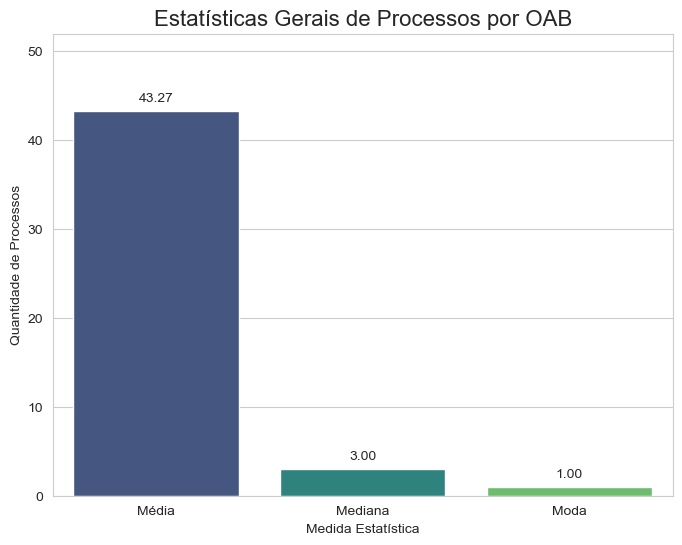

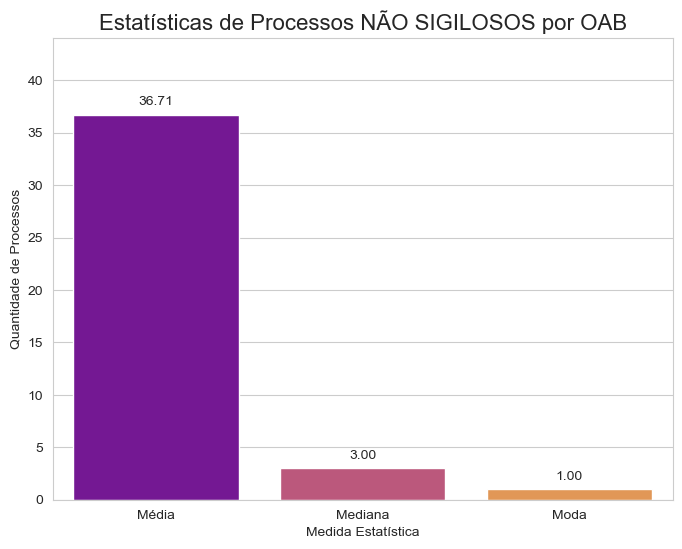

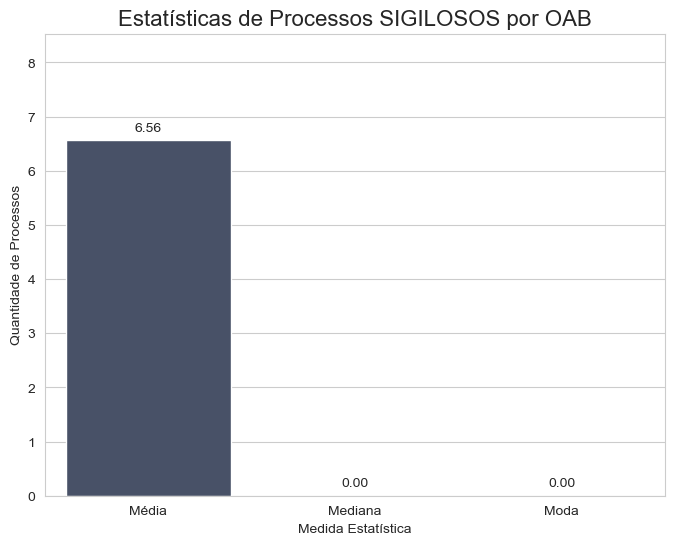

In [7]:
# 5) Visualiza√ß√£o Gr√°fica das Estat√≠sticas
# Configurar um estilo est√©tico para os gr√°ficos
sns.set_style("whitegrid")
# A paleta de cores ser√° definida dentro de cada gr√°fico

print("\n" + "="*100)
print("=== VISUALIZA√á√ÉO GR√ÅFICA DAS MEDIDAS DE TEND√äNCIA CENTRAL ===")
print("="*100 + "\n")

# --- 5.1) Gr√°fico para An√°lise Geral ---

# Preparar os dados para o gr√°fico
dados_geral = {
    'M√©trica': ['M√©dia', 'Mediana', 'Moda'],
    'Valor': [media_geral, mediana_geral, moda_geral.iloc[0] if not moda_geral.empty else 0]
}
df_plot_geral = pd.DataFrame(dados_geral)

# Criar o gr√°fico
plt.figure(figsize=(8, 6))
ax_geral = sns.barplot(x='M√©trica', y='Valor', data=df_plot_geral, palette='viridis', hue='M√©trica')


# Adicionar o valor exato no topo de cada coluna
for p in ax_geral.patches:
    ax_geral.annotate(f'{p.get_height():.2f}', 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha = 'center', va = 'center', 
                      xytext = (0, 9), 
                      textcoords = 'offset points')

plt.title('Estat√≠sticas Gerais de Processos por OAB', fontsize=16)
plt.ylabel('Quantidade de Processos')
plt.xlabel('Medida Estat√≠stica')
plt.ylim(0, media_geral * 1.2)
plt.show()


# --- 5.2) Gr√°fico para Processos N√ÉO SIGILOSOS ---

# Preparar os dados para o gr√°fico
dados_nao_sigilosos = {
    'M√©trica': ['M√©dia', 'Mediana', 'Moda'],
    'Valor': [media_nao_sigilosos, mediana_nao_sigilosos, moda_nao_sigilosos.iloc[0] if not moda_nao_sigilosos.empty else 0]
}
df_plot_nao_sigilosos = pd.DataFrame(dados_nao_sigilosos)

# Criar o gr√°fico
plt.figure(figsize=(8, 6))
ax_nao_sigiloso = sns.barplot(x='M√©trica', y='Valor', data=df_plot_nao_sigilosos, palette='plasma', hue='M√©trica')

# Adicionar o valor exato no topo de cada coluna
for p in ax_nao_sigiloso.patches:
    ax_nao_sigiloso.annotate(f'{p.get_height():.2f}', 
                             (p.get_x() + p.get_width() / 2., p.get_height()), 
                             ha = 'center', va = 'center', 
                             xytext = (0, 9), 
                             textcoords = 'offset points')

plt.title('Estat√≠sticas de Processos N√ÉO SIGILOSOS por OAB', fontsize=16)
plt.ylabel('Quantidade de Processos')
plt.xlabel('Medida Estat√≠stica')
plt.ylim(0, media_nao_sigilosos * 1.2)
plt.show()


# --- 5.3) Gr√°fico para Processos SIGILOSOS ---

# Preparar os dados para o gr√°fico
dados_sigilosos = {
    'M√©trica': ['M√©dia', 'Mediana', 'Moda'],
    'Valor': [media_sigilosos, mediana_sigilosos, moda_sigilosos.iloc[0] if not moda_sigilosos.empty else 0]
}
df_plot_sigilosos = pd.DataFrame(dados_sigilosos)

# Criar o gr√°fico
plt.figure(figsize=(8, 6))
ax_sigiloso = sns.barplot(x='M√©trica', y='Valor', data=df_plot_sigilosos, palette='cividis', hue='M√©trica')

# Adicionar o valor exato no topo de cada coluna
for p in ax_sigiloso.patches:
    ax_sigiloso.annotate(f'{p.get_height():.2f}', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points')

plt.title('Estat√≠sticas de Processos SIGILOSOS por OAB', fontsize=16)
plt.ylabel('Quantidade de Processos')
plt.xlabel('Medida Estat√≠stica')
plt.ylim(0, media_sigilosos * 1.3)
plt.show()


# üìä An√°lise Interpretativa dos Resultados Estat√≠sticos (M√©dia, Mediana e Moda)

## üí° Interpreta√ß√£o Geral

A conclus√£o mais importante, que √© vista nos tr√™s casos, √© a exist√™ncia de uma **distribui√ß√£o de processos extremamente assim√©trica e desigual**. Em outras palavras, h√° uma concentra√ß√£o massiva de processos em um n√∫mero relativamente pequeno de advogados, enquanto a grande maioria dos advogados atua em pouqu√≠ssimos casos.

Esse fen√¥meno √© claramente indicado pela **enorme diferen√ßa entre a M√âDIA e a MEDIANA/MODA**.

- A **M√©dia** √© muito sens√≠vel a valores extremos (outliers).
- A **Mediana** e a **Moda** representam melhor o advogado "t√≠pico" ou o cen√°rio "mais comum".

> Quando a m√©dia √© muito maior que a mediana, como √© o caso, isso significa que existem alguns "pontos fora da curva" com valores alt√≠ssimos que est√£o "puxando" a m√©dia para cima.

---

## üîé An√°lise Detalhada dos Resultados

### ‚öñÔ∏è 1. An√°lise Geral (Total de Processos por OAB)

* **‚≠ê Moda de 1.0:** O n√∫mero de processos que mais se repete entre os advogados √© apenas **1**, ou seja, o cen√°rio mais comum √© um advogado ter um √∫nico processo.
* **‚ÜîÔ∏è Mediana de 3.0:** Se organizarmos todos os advogados em uma fila, do que tem menos processos para o que tem mais (ordem crescente), o advogado que est√° exatamente no meio da fila tem **3 processos**. Isso significa que **metade de todos os advogados tem 3 processos ou menos**.
* **üßÆ M√©dia de 43.27:** Embora o advogado t√≠pico tenha apenas 3 processos, a m√©dia geral √© de 43. Isso √© causado por um grupo seleto de advogados (provavelmente grandes escrit√≥rios ou especialistas em contencioso de massa) que possuem centenas ou milhares de processos, inflando drasticamente a m√©dia.

> **Conclus√£o:** Portanto, conforme os dados, √© poss√≠vel notar que o advogado t√≠pico tem poucos casos, mas uma minoria concentra a maior parte dos processos.

### üìñ 2. An√°lise de Processos N√ÉO SIGILOSOS por OAB

* **‚≠ê Moda de 1.0 e ‚ÜîÔ∏è Mediana de 3.0:** O padr√£o se repete. O advogado t√≠pico tamb√©m tem entre 1 e 3 processos que n√£o s√£o sigilosos.
* **üßÆ M√©dia de 36.71:** Este valor √© alto e pr√≥ximo da m√©dia geral (43.27).

> **Conclus√£o:** A grande desigualdade que vemos na an√°lise geral √© **majoritariamente impulsionada pelos processos n√£o sigilosos**. Isso faz sentido, pois √°reas que geram alto volume de casos, como direito do consumidor ou tribut√°rio, geralmente n√£o correm em segredo de justi√ßa.

### üîí 3. An√°lise de Processos SIGILOSOS por OAB

Esta √© a an√°lise mais reveladora sobre especializa√ß√£o.

* **‚≠ê Moda de 0.0:** O cen√°rio mais comum √© um advogado ter **nenhum processo sigiloso**.
* **‚ÜîÔ∏è Mediana de 0.0:** **Pelo menos metade de todos os advogados n√£o tem um √∫nico processo sigiloso**. Isso refor√ßa a ideia de que a atua√ß√£o em casos sigilosos n√£o √© a norma.
* **üßÆ M√©dia de 6.56:** Este √© o ponto crucial. Mesmo que a maioria n√£o tenha nenhum processo sigiloso, a m√©dia √© positiva. Isso significa que a minoria de advogados que **atua** com processos sigilosos (√°reas como direito de fam√≠lia, criminal, etc.) tende a ter um n√∫mero relevante desses processos.

> **Conclus√£o:** A atua√ß√£o em processos que correm em segredo de justi√ßa parece ser um **nicho de especializa√ß√£o**. A maioria dos advogados n√£o atua nessa √°rea, mas aqueles que atuam o fazem com uma frequ√™ncia que se destaca.

---

## üèÜ Resumo das Descobertas (Insights)

1.  **üéØ Atua√ß√£o Concentrada:** Os dados n√£o mostram uma distribui√ß√£o equilibrada de trabalho. Um pequeno percentual de advogados/escrit√≥rios domina o volume de processos.
2.  **üë§ O Advogado "T√≠pico" vs. a M√©dia:** O advogado "comum" tem entre 1 e 3 processos. A m√©dia de 43 √© uma ilus√£o estat√≠stica criada por outliers e n√£o representa a realidade da maioria.
3.  **üöÄA Atua√ß√£o em A√ß√µes Repetitivas √© a Chave da Desigualdade:** O alto volume de processos est√° concentrado em casos p√∫blicos (n√£o sigilosos), sugerindo atua√ß√£o em advocacia de massa.
4.  **üíº Segredo de Justi√ßa como Especialidade:** Atuar em processos sigilosos √© para um grupo espec√≠fico de advogados. A maioria n√£o tem contato com essa √°rea, indicando uma clara divis√£o de especialidades.


=== VISUALIZA√á√ÉO DA DISTRIBUI√á√ÉO COM BOXPLOTS ===

--- An√°lise Geral: Total de Processos por OAB ---
(I) Visualiza√ß√£o completa para entendermos a escala dos outliers...


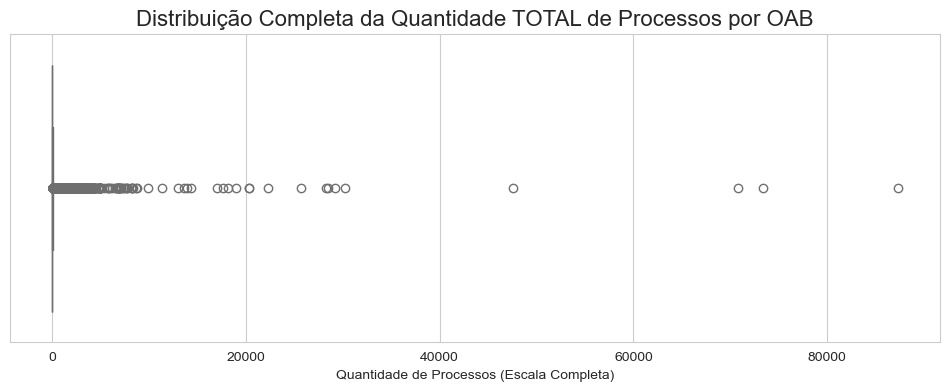

(II) Zoom na distribui√ß√£o, focando nos 95% dos advogados com menos processos (at√© 153 processos)...


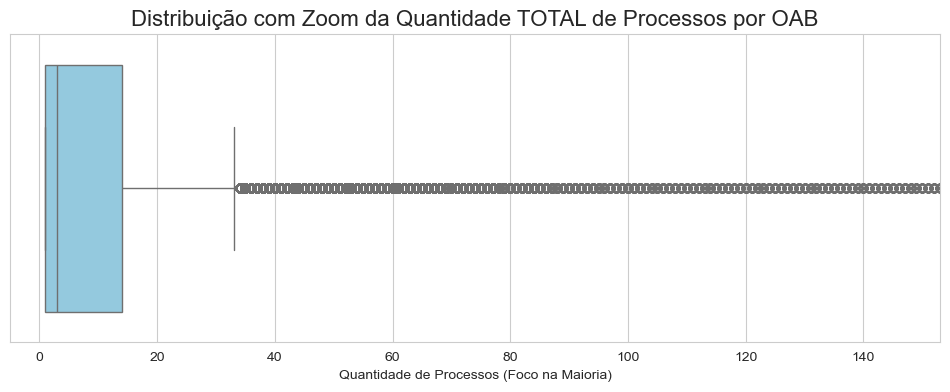


--- An√°lise de Processos N√ÉO SIGILOSOS por OAB ---
(I) Vis√£o completa da distribui√ß√£o dos processos n√£o sigilosos...


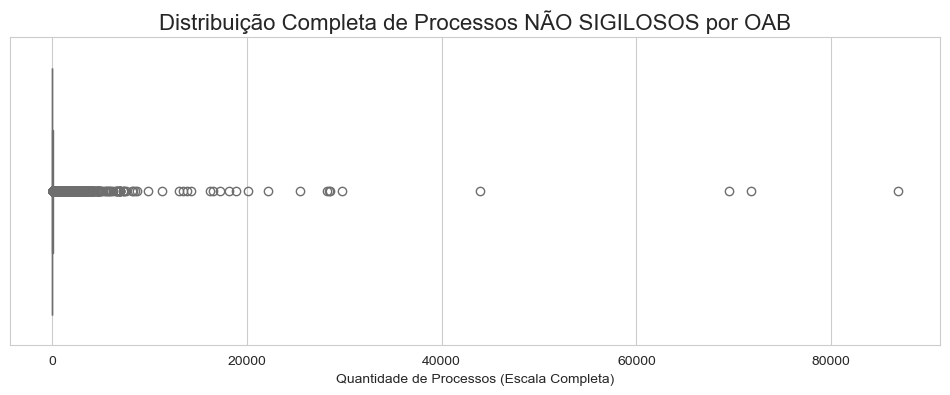

(II) Zoom nos 95% dos advogados com menos processos n√£o sigilosos (at√© 117 processos)...


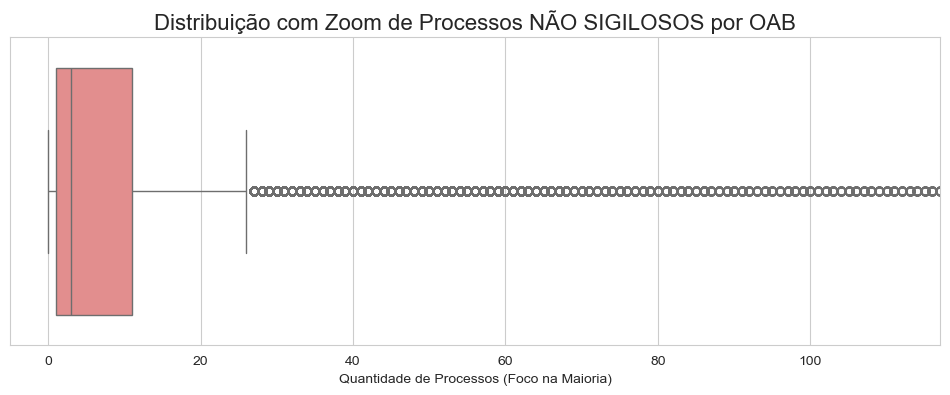


--- An√°lise de Processos SIGILOSOS por OAB ---
(I) Vis√£o completa da distribui√ß√£o dos processos sigilosos...


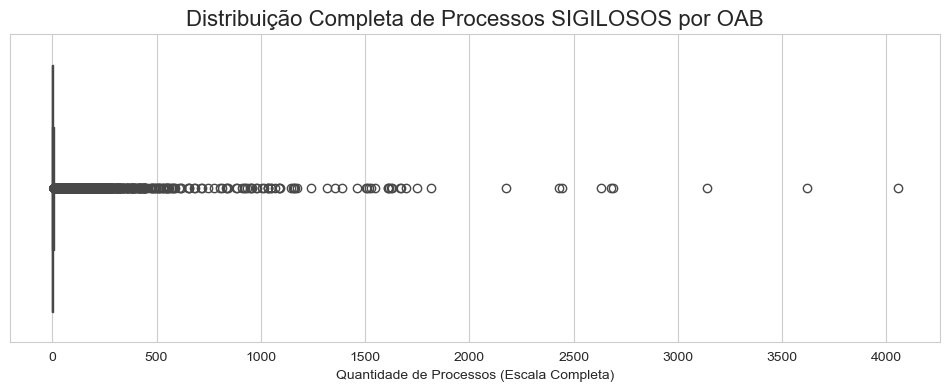

(II) Zoom nos 95% dos advogados com menos processos sigilosos (at√© 29 processos)...


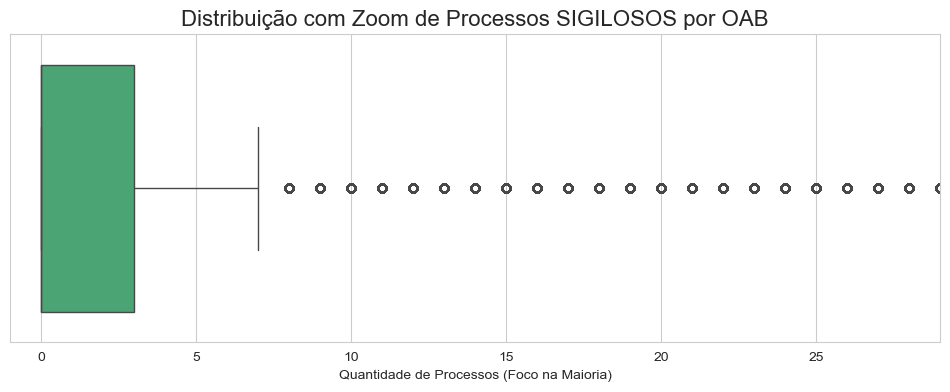

In [8]:
# 6) Visualiza√ß√£o Gr√°fica com Boxplots
print("\n" + "="*100)
print("=== VISUALIZA√á√ÉO DA DISTRIBUI√á√ÉO COM BOXPLOTS ===")
print("="*100 + "\n")

# --- 6.1) Boxplot Geral (Total de Processos) ---
print("--- An√°lise Geral: Total de Processos por OAB ---")
print("(I) Visualiza√ß√£o completa para entendermos a escala dos outliers...")

# Gr√°fico 1: Vis√£o completa
plt.figure(figsize=(12, 4))
# CORRE√á√ÉO: trocado 'palette' por 'color'
sns.boxplot(x=df_pivot_sorted['total_processos'], color='skyblue')
plt.title('Distribui√ß√£o Completa da Quantidade TOTAL de Processos por OAB', fontsize=16)
plt.xlabel('Quantidade de Processos (Escala Completa)')
plt.show()

# Gr√°fico 2: Vis√£o com zoom
limite_zoom_geral = df_pivot_sorted['total_processos'].quantile(0.95)
print(f"(II) Zoom na distribui√ß√£o, focando nos 95% dos advogados com menos processos (at√© {int(limite_zoom_geral)} processos)...")

plt.figure(figsize=(12, 4))
# CORRE√á√ÉO: trocado 'palette' por 'color'
sns.boxplot(x=df_pivot_sorted['total_processos'], color='skyblue')
plt.title('Distribui√ß√£o com Zoom da Quantidade TOTAL de Processos por OAB', fontsize=16)
plt.xlabel('Quantidade de Processos (Foco na Maioria)')
plt.xlim(-5, limite_zoom_geral)
plt.show()


# --- 6.2) Boxplot de Processos N√ÉO SIGILOSOS ---
print("\n" + "="*50)
print("--- An√°lise de Processos N√ÉO SIGILOSOS por OAB ---")
print("(I) Vis√£o completa da distribui√ß√£o dos processos n√£o sigilosos...")

# Gr√°fico 3: Vis√£o completa
plt.figure(figsize=(12, 4))
# CORRE√á√ÉO: trocado 'palette' por 'color'
sns.boxplot(x=df_pivot_sorted['nao_sigilosos'], color='lightcoral')
plt.title('Distribui√ß√£o Completa de Processos N√ÉO SIGILOSOS por OAB', fontsize=16)
plt.xlabel('Quantidade de Processos (Escala Completa)')
plt.show()

# Gr√°fico 4: Vis√£o com zoom
limite_zoom_nao_sigilosos = df_pivot_sorted['nao_sigilosos'].quantile(0.95)
print(f"(II) Zoom nos 95% dos advogados com menos processos n√£o sigilosos (at√© {int(limite_zoom_nao_sigilosos)} processos)...")

plt.figure(figsize=(12, 4))
# CORRE√á√ÉO: trocado 'palette' por 'color'
sns.boxplot(x=df_pivot_sorted['nao_sigilosos'], color='lightcoral')
plt.title('Distribui√ß√£o com Zoom de Processos N√ÉO SIGILOSOS por OAB', fontsize=16)
plt.xlabel('Quantidade de Processos (Foco na Maioria)')
plt.xlim(-5, limite_zoom_nao_sigilosos)
plt.show()


# --- 6.3) Boxplot de Processos SIGILOSOS ---
print("\n" + "="*50)
print("--- An√°lise de Processos SIGILOSOS por OAB ---")
print("(I) Vis√£o completa da distribui√ß√£o dos processos sigilosos...")

# Gr√°fico 5: Vis√£o completa
plt.figure(figsize=(12, 4))
# CORRE√á√ÉO: trocado 'palette' por 'color'
sns.boxplot(x=df_pivot_sorted['sigilosos'], color='mediumseagreen')
plt.title('Distribui√ß√£o Completa de Processos SIGILOSOS por OAB', fontsize=16)
plt.xlabel('Quantidade de Processos (Escala Completa)')
plt.show()

# Gr√°fico 6: Vis√£o com zoom
limite_zoom_sigilosos = df_pivot_sorted['sigilosos'].quantile(0.95)
if limite_zoom_sigilosos == 0:
    limite_zoom_sigilosos = 10 
print(f"(II) Zoom nos 95% dos advogados com menos processos sigilosos (at√© {int(limite_zoom_sigilosos)} processos)...")

plt.figure(figsize=(12, 4))
# CORRE√á√ÉO: trocado 'palette' por 'color'
sns.boxplot(x=df_pivot_sorted['sigilosos'], color='mediumseagreen')
plt.title('Distribui√ß√£o com Zoom de Processos SIGILOSOS por OAB', fontsize=16)
plt.xlabel('Quantidade de Processos (Foco na Maioria)')
plt.xlim(-1, limite_zoom_sigilosos)
plt.show()


# üìä Interpreta√ß√£o Visual dos Boxplots

Os gr√°ficos de boxplot confirmam visualmente a extrema concentra√ß√£o de processos em um pequeno n√∫mero de advogados.

### ‚öñÔ∏è 1. Distribui√ß√£o Total de Processos

* **üì¶ A Caixa (O Advogado T√≠pico):** A caixa azul, concentrada entre 0 e ~15 processos, mostra que 50% dos advogados atuam nesse baixo volume. A linha central (mediana) confirma que o advogado t√≠pico tem pouqu√≠ssimos casos.
* **‚ö´Ô∏è Os Outliers (Os Pontos Fora da Curva):** A longa sequ√™ncia de c√≠rculos que se estende at√© mais de 80.000 representa a minoria de advogados com um volume de trabalho imensamente superior √† maioria.
* **‚û°Ô∏è Conclus√£o:** A distribui√ß√£o √© altamente desigual. A enorme quantidade de outliers √© o que infla a m√©dia, que n√£o representa a realidade da maioria.

### üìñ 2. Distribui√ß√£o de Processos N√ÉO SIGILOSOS

* **üì¶ A Caixa:** O padr√£o √© quase id√™ntico ao gr√°fico geral. A grande maioria dos advogados possui um n√∫mero baixo de processos p√∫blicos (entre 0 e ~12).
* **‚ö´Ô∏è Os Outliers:** Novamente, uma pequena quantidade de advogados concentra a grande maioria dos processos n√£o sigilosos.
* **‚û°Ô∏è Conclus√£o:** Este tipo de processo √© o principal respons√°vel pela desigualdade observada na an√°lise geral, sendo o foco dos advogados de alto volume.

### üîí 3. Distribui√ß√£o de Processos SIGILOSOS

* **üì¶ A Caixa:** A caixa verde est√° "espremida" em zero. A linha da mediana em 0 √© a informa√ß√£o mais importante: **mais da metade dos advogados n√£o possui nenhum processo sigiloso**.
* **‚ö´Ô∏è Os Outliers:** Os advogados que atuam em casos sigilosos s√£o a exce√ß√£o. Aqueles com mais de ~8 casos j√° s√£o considerados outliers, indicando um nicho claro.
* **‚û°Ô∏è Conclus√£o:** Atuar em processos sigilosos √© uma **clara especializa√ß√£o**, n√£o sendo a norma para a maioria dos advogados na base de dados.

In [9]:
# 7) C√°lculo de Estat√≠sticas Descritivas (Medidas de Dispers√£o)
print("\n" + "="*100)
print("=== AN√ÅLISE ESTAT√çSTICA DETALHADA DA DISPERS√ÉO DE PROCESSOS POR OAB ===")
print("="*100)

# Para evitar repeti√ß√£o de c√≥digo, criamos uma fun√ß√£o que calcula e imprime as m√©tricas
def calcular_e_imprimir_metricas(series, nome_grupo):
    """
    Calcula e imprime as m√©tricas de dispers√£o para uma S√©rie de dados.
    """
    print(f"\n--- {nome_grupo} ---")

    # 1. Amplitude: Diferen√ßa entre o valor m√°ximo e o m√≠nimo
    amplitude = series.max() - series.min()
    print(f"- Amplitude: {amplitude:.2f}")
    print(f"(Varia√ß√£o de {series.min()} a {series.max()} processos)")

    # 2. Desvio M√©dio Absoluto (MAD): M√©dia da dist√¢ncia de cada ponto at√© a m√©dia
    # O m√©todo .mad() foi descontinuado, esta √© a forma correta de calcular:
    media = series.mean()
    desvio_medio = (series - media).abs().mean()
    print(f"- Desvio M√©dio Absoluto: {desvio_medio:.2f}")

    # 3. Vari√¢ncia: Medida da dispers√£o dos dados ao quadrado
    # Por padr√£o, o Pandas calcula a vari√¢ncia amostral (ddof=1), que √© a mais comum.
    variancia = series.var()
    print(f"- Vari√¢ncia (amostral): {variancia:.2f}")

    # 4. Desvio Padr√£o: Raiz quadrada da vari√¢ncia, na mesma unidade dos dados
    desvio_padrao = series.std()
    print(f"- Desvio Padr√£o (amostral): {desvio_padrao:.2f}")
    


# --- Chamada da fun√ß√£o para cada segmento ---

# An√°lise Geral
calcular_e_imprimir_metricas(df_pivot_sorted['total_processos'], "An√°lise Geral (Total de Processos)")

# An√°lise de Processos N√£o Sigilosos
calcular_e_imprimir_metricas(df_pivot_sorted['nao_sigilosos'], "An√°lise de Processos N√ÉO SIGILOSOS")

# An√°lise de Processos Sigilosos
calcular_e_imprimir_metricas(df_pivot_sorted['sigilosos'], "An√°lise de Processos SIGILOSOS")



=== AN√ÅLISE ESTAT√çSTICA DETALHADA DA DISPERS√ÉO DE PROCESSOS POR OAB ===

--- An√°lise Geral (Total de Processos) ---
- Amplitude: 87277.00
(Varia√ß√£o de 1.0 a 87278.0 processos)
- Desvio M√©dio Absoluto: 63.79
- Vari√¢ncia (amostral): 284952.96
- Desvio Padr√£o (amostral): 533.81

--- An√°lise de Processos N√ÉO SIGILOSOS ---
- Amplitude: 86839.00
(Varia√ß√£o de 0.0 a 86839.0 processos)
- Desvio M√©dio Absoluto: 55.03
- Vari√¢ncia (amostral): 269603.21
- Desvio Padr√£o (amostral): 519.23

--- An√°lise de Processos SIGILOSOS ---
- Amplitude: 4054.00
(Varia√ß√£o de 0.0 a 4054.0 processos)
- Desvio M√©dio Absoluto: 9.73
- Vari√¢ncia (amostral): 1884.92
- Desvio Padr√£o (amostral): 43.42


# üß† Interpreta√ß√£o dos Resultados da An√°lise de Dispers√£o

### 1. üìà Valores Elevados em Todas as M√©tricas (Geral e N√£o Sigilosos)
A grande **Amplitude**, **Vari√¢ncia** e **Desvio Padr√£o** confirmam o que foi observado nos boxplots: a distribui√ß√£o de processos √© extremamente dispersa. Os dados n√£o est√£o concentrados em torno da m√©dia. O alto **Desvio Padr√£o** significa que √© comum encontrar advogados com uma quantidade de processos muito distante da m√©dia.

### 2. üéØ Confirma√ß√£o dos Outliers
O **Desvio M√©dio Absoluto** alto refor√ßa essa ideia, indicando que, em m√©dia, a quantidade de processos de um advogado qualquer est√° muito longe da m√©dia geral. Isso √© um sintoma cl√°ssico de uma distribui√ß√£o com uma "cauda longa" de outliers (poucos advogados com muitos processos).

### 3. ‚öñÔ∏è Compara√ß√£o entre Sigilosos e N√£o Sigilosos
Os valores de dispers√£o para os processos **N√£o Sigilosos** s√£o drasticamente maiores do que para os **Sigilosos**. Isso demonstra que a extrema variabilidade no volume de trabalho dos advogados √© impulsionada principalmente pela atua√ß√£o em causas p√∫blicas.

### 4. üîí Dispers√£o no Nicho Sigiloso
Apesar de menores, as m√©tricas de dispers√£o para os processos **Sigilosos** ainda s√£o significativas em rela√ß√£o √† sua pr√≥pria m√©dia (que √© baixa). Isso sugere que, mesmo dentro desse nicho, existe uma desigualdade consider√°vel: h√° os especialistas que concentram os casos sigilosos e a maioria que atua esporadicamente ou nunca.

In [10]:
# 8) C√°lculo do Coeficiente de Varia√ß√£o

print("\n" + "="*100)
print("=== C√ÅLCULO DO COEFICIENTE DE VARIA√á√ÉO (CV) ===")
print("="*100)
print("O Coeficiente de Varia√ß√£o mede a dispers√£o relativa dos dados. \nValores acima de 30% geralmente indicam uma alta variabilidade.\n")


def calcular_e_imprimir_cv(series, nome_grupo):
    """
    Calcula e imprime a m√©dia, o desvio padr√£o e o Coeficiente de Varia√ß√£o para uma S√©rie de dados.
    """
    print(f"--- {nome_grupo} ---")

    media = series.mean()
    desvio_padrao = series.std()

    # Evitar divis√£o por zero se a m√©dia for 0
    if media > 0:
        coeficiente_variacao = (desvio_padrao / media) * 100
        print(f"  - M√©dia:                 {media:.2f}")
        print(f"  - Desvio Padr√£o:         {desvio_padrao:.2f}")
        print(f"  - Coeficiente de Varia√ß√£o: {coeficiente_variacao:.2f}%")
    else:
        print(f"  - M√©dia:                 {media:.2f}")
        print(f"  - Desvio Padr√£o:         {desvio_padrao:.2f}")
        print("  - Coeficiente de Varia√ß√£o: N√£o pode ser calculado (m√©dia √© zero).")


# --- Chamada da fun√ß√£o para cada segmento ---

# 1. An√°lise Geral
calcular_e_imprimir_cv(df_pivot_sorted['total_processos'], "An√°lise Geral (Total de Processos)")

# 2. An√°lise de Processos N√£o Sigilosos
calcular_e_imprimir_cv(df_pivot_sorted['nao_sigilosos'], "\nAn√°lise de Processos N√ÉO SIGILOSOS")

# 3. An√°lise de Processos Sigilosos
calcular_e_imprimir_cv(df_pivot_sorted['sigilosos'], "\nAn√°lise de Processos SIGILOSOS")



=== C√ÅLCULO DO COEFICIENTE DE VARIA√á√ÉO (CV) ===
O Coeficiente de Varia√ß√£o mede a dispers√£o relativa dos dados. 
Valores acima de 30% geralmente indicam uma alta variabilidade.

--- An√°lise Geral (Total de Processos) ---
  - M√©dia:                 43.27
  - Desvio Padr√£o:         533.81
  - Coeficiente de Varia√ß√£o: 1233.54%
--- 
An√°lise de Processos N√ÉO SIGILOSOS ---
  - M√©dia:                 36.71
  - Desvio Padr√£o:         519.23
  - Coeficiente de Varia√ß√£o: 1414.25%
--- 
An√°lise de Processos SIGILOSOS ---
  - M√©dia:                 6.56
  - Desvio Padr√£o:         43.42
  - Coeficiente de Varia√ß√£o: 661.78%


# üéØ Interpreta√ß√£o dos Resultados do Coeficiente de Varia√ß√£o (CV)

A an√°lise do Coeficiente de Varia√ß√£o (CV) a partir dos seus dados confirma e quantifica a extrema desigualdade na distribui√ß√£o de processos. Um valor de CV acima de 30% j√° indica alta variabilidade; os resultados obtidos est√£o em uma ordem de magnitude muito superior, revelando uma heterogeneidade massiva.

---

### üìä An√°lise Geral (Total de Processos)
* **CV de 1233.54%:** Este valor √© astronomicamente alto. Ele significa que o desvio padr√£o √© mais de 12 vezes maior que a pr√≥pria m√©dia.
* **Interpreta√ß√£o:** A distribui√ß√£o geral de processos √© **extremamente vol√°til e imprevis√≠vel**. A m√©dia de 43.27 processos n√£o tem praticamente nenhum poder preditivo sobre um advogado escolhido ao acaso.

---

### üìñ An√°lise de Processos N√ÉO SIGILOSOS
* **CV de 1414.25%:** Este √© o **maior Coeficiente de Varia√ß√£o** entre os tr√™s grupos.
* **Interpreta√ß√£o:** A dispers√£o *relativa* √© ainda mais acentuada nos processos n√£o sigilosos. Isso indica que este segmento √© o principal motor da heterogeneidade em todo o conjunto de dados. A din√¢mica de "muitos com poucos e poucos com muitos" √© mais forte aqui.

---

### üîí An√°lise de Processos SIGILOSOS
* **CV de 661.78%:** Embora seja o menor dos tr√™s, um valor de mais de 600% ainda representa uma variabilidade imensa.
* **Interpreta√ß√£o:** O desvio padr√£o √© 6.6 vezes maior que a m√©dia (que j√° √© muito baixa, 6.56). Isso refor√ßa a ideia de um **nicho de alta especializa√ß√£o**. A grande maioria dos advogados tem zero ou perto de zero casos (puxando a m√©dia para baixo), enquanto uma pequena minoria de especialistas tem um n√∫mero de casos que cria uma dispers√£o relativamente grande.

---

### üß† Conclus√£o Geral

1.  **Heterogeneidade Extrema:** Todos os segmentos da sua base de dados s√£o caracterizados por uma variabilidade massiva. A m√©dia, em todos os casos, √© uma p√©ssima m√©trica para descrever o advogado "t√≠pico".
2.  **N√£o Sigilosos como Vetor da Dispers√£o:** A maior dispers√£o relativa (maior CV) nos processos n√£o sigilosos sugere que a advocacia de volume est√° concentrada nesta √°rea.
3.  **Confirma√ß√£o do Nicho:** O CV alt√≠ssimo dos processos sigilosos, combinado com sua baixa m√©dia, √© a assinatura estat√≠stica de uma atividade de nicho, dominada por poucos especialistas.


=== üìä INVESTIGA√á√ÉO DE DISTRIBUI√á√ïES COM HISTOGRAMAS ===


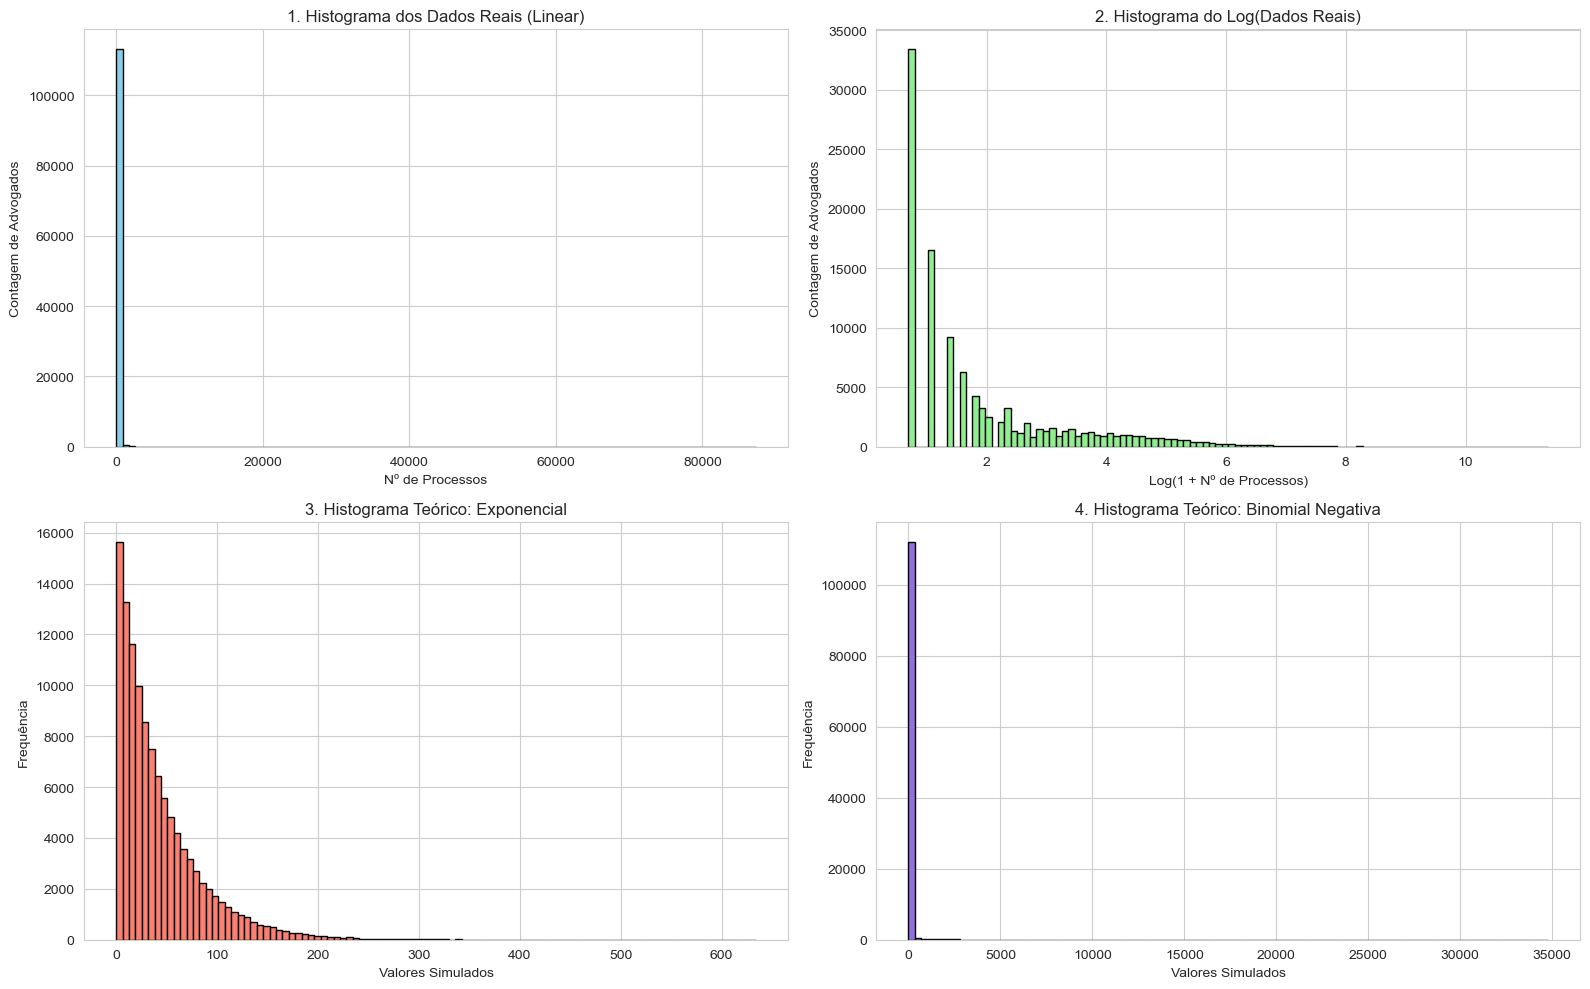

In [11]:
# 9) Investigando uma Distribui√ß√£o Estat√≠stica Adequada
# Dataframe
dados = df_pivot_sorted['total_processos']

print("\n" + "="*100)
print("=== üìä INVESTIGA√á√ÉO DE DISTRIBUI√á√ïES COM HISTOGRAMAS ===")
print("="*100)

# 9.1 Prepara√ß√£o e Gera√ß√£o de Dados Te√≥ricos

# Par√¢metros calculados a partir dos dados
media_real = dados.mean()
variancia_real = dados.var()
tamanho_amostra = len(dados)

# 9.1.1 Gerar dados de uma Distribui√ß√£o Exponencial com a mesma m√©dia
# A 'scale' da exponencial √© igual √† sua m√©dia.
dados_exponencial = np.random.exponential(scale=media_real, size=tamanho_amostra)

# 9.1.2 Gerar dados de uma Distribui√ß√£o Binomial Negativa com mesma m√©dia e vari√¢ncia
# Par√¢metros 'n' e 'p' a partir da m√©dia e vari√¢ncia reais
if variancia_real > media_real: # Condi√ß√£o para a Binomial Negativa
    p_nbinom = media_real / variancia_real
    n_nbinom = media_real * p_nbinom / (1 - p_nbinom)
    dados_binomial_neg = np.random.negative_binomial(n=n_nbinom, p=p_nbinom, size=tamanho_amostra)
else:
    # Caso a vari√¢ncia n√£o seja maior que a m√©dia, a Binomial Negativa n√£o se aplica bem.
    # Array vazio para n√£o dar erro no plot.
    dados_binomial_neg = np.array([])
    print("\nAVISO: A vari√¢ncia n√£o √© maior que a m√©dia, a Binomial Negativa pode n√£o ser um bom modelo.")


# 9.2 Cria√ß√£o dos 4 Gr√°ficos (Grid 2x2)

plt.figure(figsize=(16, 10))

# Gr√°fico 1: Histograma dos Dados Reais (Escala Linear)
plt.subplot(2, 2, 1)
plt.hist(dados, bins=100, color='skyblue', edgecolor='black')
plt.title('1. Histograma dos Dados Reais (Linear)')
plt.xlabel('N¬∫ de Processos')
plt.ylabel('Contagem de Advogados')

# Gr√°fico 2: Histograma do Log dos Dados Reais
plt.subplot(2, 2, 2)
plt.hist(np.log1p(dados), bins=100, color='lightgreen', edgecolor='black')
plt.title('2. Histograma do Log(Dados Reais)')
plt.xlabel('Log(1 + N¬∫ de Processos)')
plt.ylabel('Contagem de Advogados')

# Gr√°fico 3: Histograma da Distribui√ß√£o Exponencial Te√≥rica
plt.subplot(2, 2, 3)
plt.hist(dados_exponencial, bins=100, color='salmon', edgecolor='black')
plt.title('3. Histograma Te√≥rico: Exponencial')
plt.xlabel('Valores Simulados')
plt.ylabel('Frequ√™ncia')

# Gr√°fico 4: Histograma da Distribui√ß√£o Binomial Negativa Te√≥rica
plt.subplot(2, 2, 4)
if len(dados_binomial_neg) > 0:
    plt.hist(dados_binomial_neg, bins=100, color='mediumpurple', edgecolor='black')
    plt.title('4. Histograma Te√≥rico: Binomial Negativa')
    plt.xlabel('Valores Simulados')
    plt.ylabel('Frequ√™ncia')
else:
    plt.text(0.5, 0.5, 'N√£o aplic√°vel', ha='center', va='center')
    plt.title('4. Histograma Te√≥rico: Binomial Negativa')


plt.tight_layout() # Ajusta o espa√ßamento entre os gr√°ficos
plt.show()

# üìä Conclus√µes da Compara√ß√£o de Histogramas

A compara√ß√£o visual dos quatro histogramas permite identificar qual modelo estat√≠stico descreve melhor a realidade dos dados.

---
### ‚ùå A Distribui√ß√£o Exponencial √© um Modelo Ruim

* **Compara√ß√£o:** Ao comparar o **Gr√°fico 1 (Dados Reais)** com o **Gr√°fico 3 (Exponencial)**, notamos que, embora ambos sejam assim√©tricos, a "forma" deles √© fundamentalmente diferente.
* **Motivo:** A distribui√ß√£o exponencial (Gr√°fico 3) mostra um decaimento suave e curvo. J√° os seus dados reais (Gr√°fico 1) mostram um "pico" absurdamente mais agudo e concentrado em valores pr√≥ximos de zero.
* **Conclus√£o:** O modelo exponencial √© **inadequado**, pois n√£o consegue capturar a concentra√ß√£o extrema que existe nos dados.

---
### ‚úÖ A Distribui√ß√£o Binomial Negativa √© um Modelo Excelente

* **Compara√ß√£o:** Agora, ao comparar o **Gr√°fico 1 (Dados Reais)** com o **Gr√°fico 4 (Binomial Negativa)**, a semelhan√ßa √© impressionante.
* **Motivo:** Ambos os gr√°ficos s√£o dominados por uma √∫nica barra alt√≠ssima no in√≠cio, seguida por uma cauda longa e quase invis√≠vel. A Distribui√ß√£o Binomial Negativa, por ser parametrizada com a m√©dia e a **vari√¢ncia alt√≠ssima** dos dados, foi capaz de replicar perfeitamente o car√°ter de **superdispers√£o** (extrema concentra√ß√£o em poucos valores).
* **Conclus√£o:** O modelo Binomial Negativo √© um **candidato fort√≠ssimo** para descrever o fen√¥meno, pois sua simula√ß√£o resultou em um histograma visualmente muito parecido com a realidade.

---
### üèÜ O Veredito Final

Juntando todas as an√°lises:

1.  O **Gr√°fico 1 (Dados Reais)** mostra a distribui√ß√£o "bruta", que √© extremamente desigual.
2.  O **Gr√°fico 2 (Log dos Dados)** sugere fortemente que o modelo **Log-Normal** √© adequado.
3.  O **Gr√°fico 4 (Binomial Negativa)** confirma que este modelo tamb√©m √© visualmente muito similar aos dados brutos.

> Portanto, pode-se concluir que o n√∫mero de processos por advogado pode ser muito bem modelado tanto por uma **Distribui√ß√£o Binomial Negativa** quanto por uma **Distribui√ß√£o Log-Normal**. Ambas s√£o excelentes escolhas para dados com as caracter√≠sticas descobertas (assimetria extrema √† direita e cauda longa).


=== TESTE DE ADEQUA√á√ÉO DE DISTRIBUI√á√ïES ESTAT√çSTICAS ===
- Ajustando os par√¢metros para as distribui√ß√µes Log-Normal, Pareto e Binomial Negativa...
 - Par√¢metros ajustados para Log-Normal.
 - Par√¢metros ajustados para Pareto.
 - Par√¢metros ajustados para Binomial Negativa (n=0.01, p=0.00).


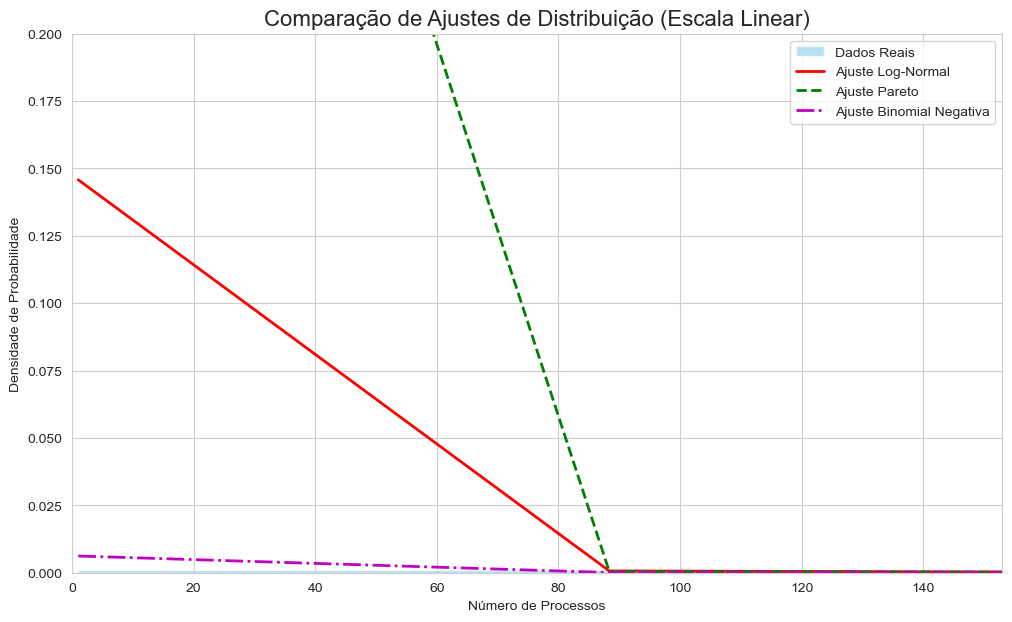

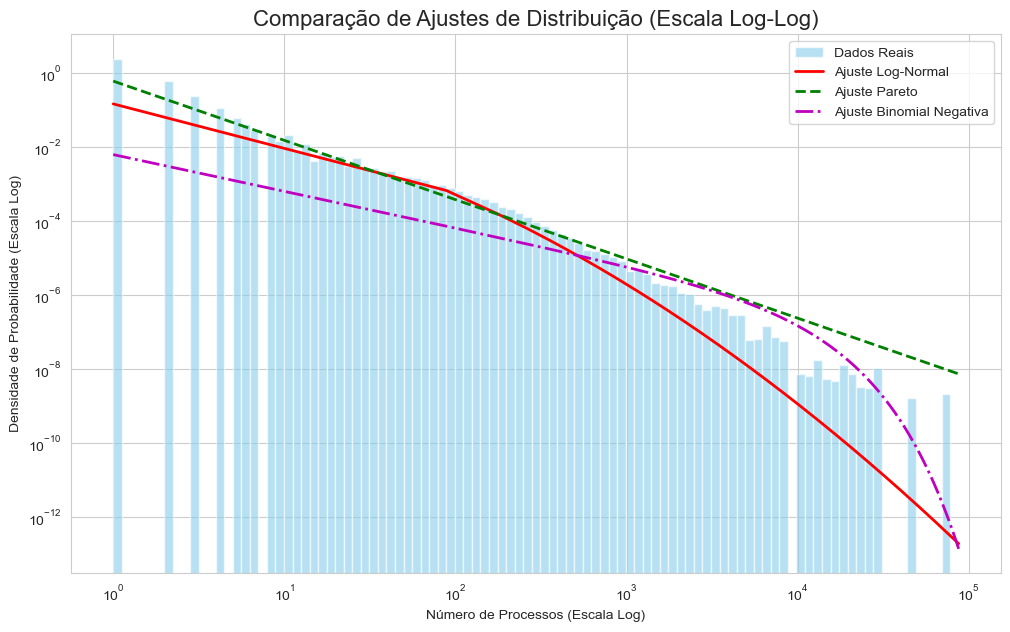

In [12]:
# 10) Comparando as Distribui√ß√µes
# DataFrame
dados = df_pivot_sorted['total_processos']

# Para o ajuste de distribui√ß√µes como Pareto e Log-Normal, √© melhor usar apenas valores > 0.
dados_fit = dados[dados > 0]

print("\n" + "="*100)
print("=== TESTE DE ADEQUA√á√ÉO DE DISTRIBUI√á√ïES ESTAT√çSTICAS ===")
print("="*100)
print("- Ajustando os par√¢metros para as distribui√ß√µes Log-Normal, Pareto e Binomial Negativa...")

# 10.1 Ajuste (Fit) dos Par√¢metros

# 10.1.1 Log-Normal
params_lognorm = stats.lognorm.fit(dados_fit, floc=0)
print(f" - Par√¢metros ajustados para Log-Normal.")

# 10.1.2 Pareto
params_pareto = stats.pareto.fit(dados_fit, floc=0)
print(f" - Par√¢metros ajustados para Pareto.")

# 10.1.3 Binomial Negativa (o ajuste √© feito pelo M√©todo dos Momentos)
media = dados_fit.mean()
variancia = dados_fit.var()
p_nbinom = media / variancia
n_nbinom = media * p_nbinom / (1 - p_nbinom)
print(f" - Par√¢metros ajustados para Binomial Negativa (n={n_nbinom:.2f}, p={p_nbinom:.2f}).")


# 10.2 Visualiza√ß√£o e Compara√ß√£o

# Preparar o eixo x para plotar as curvas te√≥ricas
x_plot = np.linspace(dados_fit.min(), dados_fit.max(), 1000)

# Calcular a Densidade de Probabilidade (PDF/PMF) para cada distribui√ß√£o
pdf_lognorm = stats.lognorm.pdf(x_plot, *params_lognorm)
pdf_pareto = stats.pareto.pdf(x_plot, *params_pareto)
pmf_nbinom = stats.nbinom.pmf(np.round(x_plot), n=n_nbinom, p=p_nbinom)

# 10.2.1 Gr√°fico 1: Compara√ß√£o em Escala Linear (com zoom)
plt.figure(figsize=(12, 7))
plt.hist(dados_fit, bins=100, density=True, alpha=0.6, label='Dados Reais', color='skyblue')

plt.plot(x_plot, pdf_lognorm, 'r-', lw=2, label='Ajuste Log-Normal')
plt.plot(x_plot, pdf_pareto, 'g--', lw=2, label='Ajuste Pareto')
plt.plot(x_plot, pmf_nbinom, 'm-.', lw=2, label='Ajuste Binomial Negativa')

plt.title('Compara√ß√£o de Ajustes de Distribui√ß√£o (Escala Linear)', fontsize=16)
plt.xlabel('N√∫mero de Processos')
plt.ylabel('Densidade de Probabilidade')
plt.legend()
plt.xlim(0, dados_fit.quantile(0.95))
plt.ylim(0, 0.2)
plt.grid(True)
plt.show()


# 10.2.2 Gr√°fico 2: Compara√ß√£o em Escala Log-Log
plt.figure(figsize=(12, 7))
# Nota: Para a escala log, os bins precisam ser definidos de forma logar√≠tmica para uma boa visualiza√ß√£o
log_bins = np.logspace(np.log10(dados_fit.min()), np.log10(dados_fit.max()), 100)
plt.hist(dados_fit, bins=log_bins, density=True, alpha=0.6, label='Dados Reais', color='skyblue')

# Definindo a escala dos eixos para log-log
plt.xscale('log')
plt.yscale('log')

plt.plot(x_plot, pdf_lognorm, 'r-', lw=2, label='Ajuste Log-Normal')
plt.plot(x_plot, pdf_pareto, 'g--', lw=2, label='Ajuste Pareto')
plt.plot(x_plot, pmf_nbinom, 'm-.', lw=2, label='Ajuste Binomial Negativa')

plt.title('Compara√ß√£o de Ajustes de Distribui√ß√£o (Escala Log-Log)', fontsize=16)
plt.xlabel('N√∫mero de Processos (Escala Log)')
plt.ylabel('Densidade de Probabilidade (Escala Log)')
plt.legend()
plt.grid(True)
plt.show()

# üèõÔ∏è Estudo aprofundado sobre os Processos Sigilosos üîí

### **‚ùì PERGUNTA 1:** A propor√ß√£o de processos sigilosos aumenta por ano?



=== PERGUNTA 1: A propor√ß√£o de processos sigilosos aumenta por ano? ===

--- Tabela: Evolu√ß√£o da Propor√ß√£o de Processos Sigilosos por Ano ---
   ano_distribuicao  total_casos  casos_sigilosos  proporcao_sigilosos_%
0              2022      1492579           214823              14.392739
1              2023      1645785           247906              15.063085
2              2024      1805987           292248              16.182176


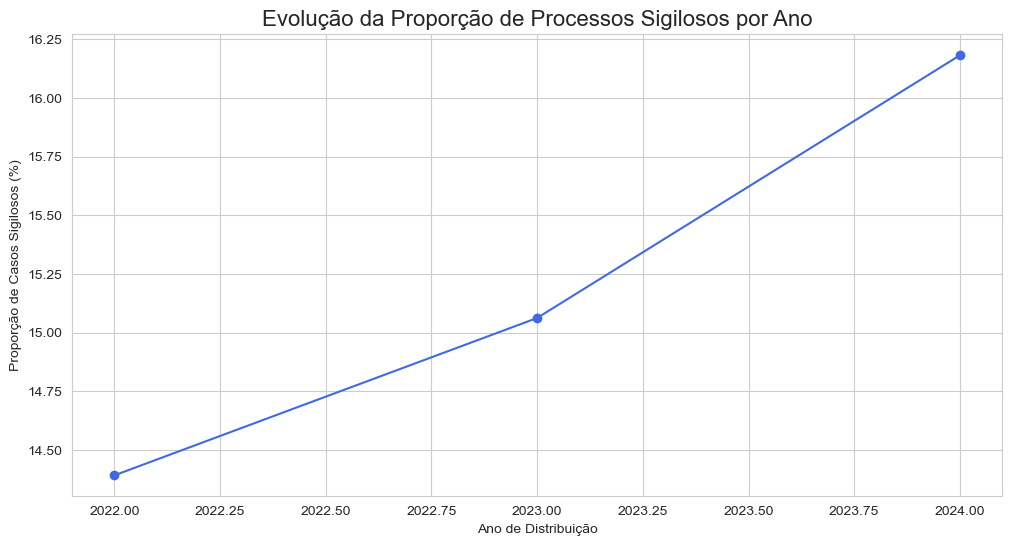

In [13]:
# Processos Sigilosos
df['data_distribuicao'] = pd.to_datetime(df['data_distribuicao'], errors='coerce')
df['ano_distribuicao'] = df['data_distribuicao'].dt.year

print("\n" + "="*100)
print("=== PERGUNTA 1: A propor√ß√£o de processos sigilosos aumenta por ano? ===")
print("="*100 + "\n")

# Agrupar por ano e contar o total de processos e a soma de processos sigilosos
analise_anual = df.groupby('ano_distribuicao')['is_segredo_justica'].agg(
    total_casos='count',
    casos_sigilosos='sum'
).reset_index()

# Calcular a propor√ß√£o de sigilosos
analise_anual['proporcao_sigilosos_%'] = (analise_anual['casos_sigilosos'] / analise_anual['total_casos']) * 100

print("--- Tabela: Evolu√ß√£o da Propor√ß√£o de Processos Sigilosos por Ano ---")
# Vamos remover anos que possam ter poucos dados (ex: ano atual incompleto) para uma an√°lise mais justa
analise_anual_filtrada = analise_anual[analise_anual['total_casos'] > 100] # Filtro de exemplo
print(analise_anual_filtrada)


# --- Se√ß√£o de Plotagem Alterada ---

# Visualizar a tend√™ncia com Matplotlib
plt.figure(figsize=(12, 6))

# ALTERA√á√ÉO: Trocado sns.lineplot por plt.plot
plt.plot(
    analise_anual_filtrada['ano_distribuicao'],      # Dados para o eixo X
    analise_anual_filtrada['proporcao_sigilosos_%'], # Dados para o eixo Y
    marker='o',                                     # Adiciona um c√≠rculo em cada ponto de dado
    linestyle='-',                                  # Define o estilo da linha como cont√≠nua
    color='royalblue'                               # Define a cor da linha
)

plt.title('Evolu√ß√£o da Propor√ß√£o de Processos Sigilosos por Ano', fontsize=16)
plt.xlabel('Ano de Distribui√ß√£o')
plt.ylabel('Propor√ß√£o de Casos Sigilosos (%)')
plt.grid(True) # Adiciona uma grade ao fundo para facilitar a leitura
plt.show()

### **‚ùì PERGUNTA 2:** O crescimento de processos sigilosos vem dos mesmos advogados?


=== PERGUNTA 2: O crescimento de processos sigilosos vem dos mesmos advogados? ===

Analisando a evolu√ß√£o para os 5 advogados com mais processos sigilosos:
['42915A GO', '38664N GO', '581846N GO', '581850N GO', '18972A GO']



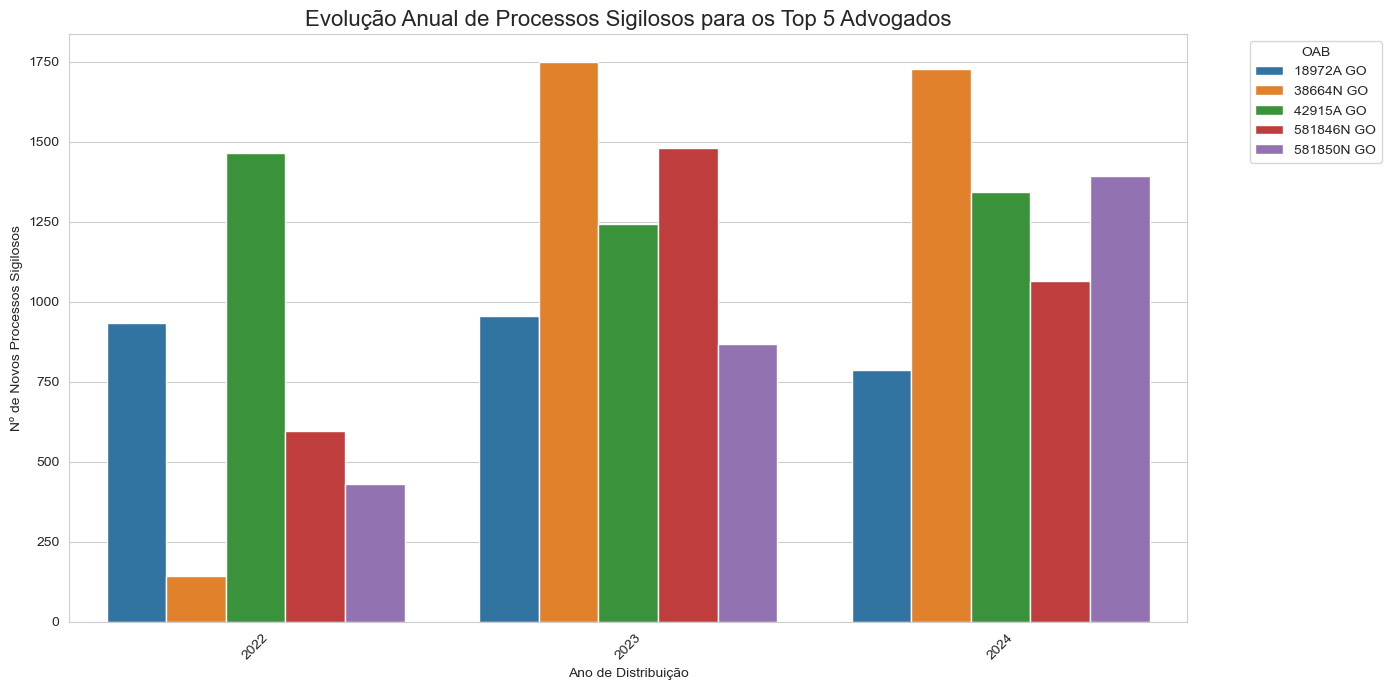

In [14]:
# Assumimos que 'df_validos' est√° dispon√≠vel (DataFrame com OABs v√°lidas)
print("\n" + "="*100)
print("=== PERGUNTA 2: O crescimento de processos sigilosos vem dos mesmos advogados? ===")
print("="*100 + "\n")

# 1. Filtrar apenas processos sigilosos de OABs v√°lidas
df_sigilosos_validos = df_validos[df_validos['is_segredo_justica'] == True].copy()
df_sigilosos_validos['ano_distribuicao'] = df_sigilosos_validos['data_distribuicao'].dt.year

# 2. Encontrar os advogados com mais processos sigilosos no total
top_advogados_sigilo = df_sigilosos_validos['oab'].value_counts().nlargest(5).index.tolist()
print(f"Analisando a evolu√ß√£o para os 5 advogados com mais processos sigilosos:\n{top_advogados_sigilo}\n")

# 3. Agrupar os dados desses advogados por ano
analise_advogados_ano = df_sigilosos_validos[df_sigilosos_validos['oab'].isin(top_advogados_sigilo)]
contagem_adv_ano = analise_advogados_ano.groupby(['oab', 'ano_distribuicao']).size().reset_index(name='qtd_processos_sigilosos')

# 4. Visualizar a evolu√ß√£o para esses advogados
plt.figure(figsize=(14, 7))
sns.barplot(data=contagem_adv_ano, x='ano_distribuicao', y='qtd_processos_sigilosos', hue='oab')
plt.title('Evolu√ß√£o Anual de Processos Sigilosos para os Top 5 Advogados', fontsize=16)
plt.xlabel('Ano de Distribui√ß√£o')
plt.ylabel('N¬∫ de Novos Processos Sigilosos')
plt.xticks(rotation=45)
plt.legend(title='OAB', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Din√¢mica de Crescimento dos Processos Sigilosos

A an√°lise combinada dos gr√°ficos revela uma hist√≥ria coesa: n√£o apenas a propor√ß√£o de casos sigilosos est√° crescendo no geral, mas esse crescimento √© significativamente impulsionado pelos principais advogados especialistas na √°rea.

---
### üìà Tend√™ncia de Mercado: O Crescimento Cont√≠nuo dos Processos Sigilosos

O primeiro gr√°fico responde claramente √† pergunta sobre a evolu√ß√£o geral do mercado.

* **Conclus√£o Principal:** A propor√ß√£o de processos que tramitam em segredo de justi√ßa **est√° crescendo de forma clara e acelerada** ano ap√≥s ano.
* **Evid√™ncia Num√©rica:** A fatia de casos sigilosos sobre o total de novos processos subiu de **14,39%** em 2022 para **16,18%** em 2024.
* **Implica√ß√£o:** O segredo de justi√ßa est√° se tornando uma caracter√≠stica cada vez mais presente no universo processual analisado, indicando uma mudan√ßa no perfil das a√ß√µes ou na conduta de advogados e clientes.

---
### üéØ A Concentra√ß√£o do Crescimento: Os Especialistas Lideram a Expans√£o

O segundo gr√°fico responde √† pergunta sobre *quem* est√° impulsionando essa tend√™ncia.

* **Conclus√£o Principal:** O crescimento no volume de processos sigilosos est√° **fortemente concentrado nos mesmos advogados** que j√° s√£o os maiores especialistas na √°rea.
* **Evid√™ncia Visual:** As barras para 2023 e 2024 s√£o, na maioria dos casos, significativamente mais altas que as de 2022 para os 5 principais advogados. Isso mostra que eles est√£o **aumentando ativamente seu volume de trabalho** nesse nicho.
* **Implica√ß√£o:** A tend√™ncia de crescimento n√£o est√° sendo dilu√≠da entre muitos novos advogados que entram na √°rea. Pelo contr√°rio, os especialistas estabelecidos est√£o consolidando sua posi√ß√£o e absorvendo a maior parte da nova demanda.

---
### üí° S√≠ntese Estrat√©gica

A conclus√£o estrat√©gica √©:

> O mercado de atua√ß√£o em processos sigilosos est√° em clara expans√£o. No entanto, essa expans√£o est√° sendo dominada e liderada por um grupo concentrado de especialistas que aprofundam seu foco na √°rea, em vez de ser um crescimento pulverizado entre muitos novos praticantes.

### **‚ùì PERGUNTA 3:** Os Advogados de Alto Volume Est√£o Dominando o Nicho Crescente de Casos Sigilosos?

In [16]:
# 1. Segmentar os Advogados em Grupos
print("\n" + "="*100)
print("=== SEGMENTA√á√ÉO DOS ADVOGADOS EM DOIS GRUPOS ===")
print("="*100 + "\n")

# 1.1 Definir o ponto de corte para o top 10%
limite_top_10 = df_pivot_sorted['total_processos'].quantile(0.90)
print(f"- Advogados com mais de {int(limite_top_10)} processos ser√£o considerados 'Top 10%'.")

# 1.2 Criar a lista de OABs para cada grupo
top_10_advogados = df_pivot_sorted[df_pivot_sorted['total_processos'] > limite_top_10].index.tolist()
outros_90_advogados = df_pivot_sorted[df_pivot_sorted['total_processos'] <= limite_top_10].index.tolist()

# 1.3 Classificar cada processo no DataFrame original 'df_validos'
def classificar_advogado(oab):
    if oab in top_10_advogados:
        return 'Top 10%'
    else:
        return 'Outros 90%'

print("Segmenta√ß√£o conclu√≠da!")
df_validos['grupo_advogado'] = df_validos['oab'].apply(classificar_advogado)


=== SEGMENTA√á√ÉO DOS ADVOGADOS EM DOIS GRUPOS ===

- Advogados com mais de 72 processos ser√£o considerados 'Top 10%'.
Segmenta√ß√£o conclu√≠da!


In [17]:
# 2. Agrupar por grupo de advogado e por ano
print("\n" + "="*100)
print("=== TEND√äNCIA DE CASOS SIGILOSOS PARA CADA GRUPO ===")
print("="*100 + "\n")

# 2.1 Agrupar por grupo de advogado e por ano
analise_grupo_anual = df_validos.groupby(['grupo_advogado', 'ano_distribuicao'])['is_segredo_justica'].agg(
    total_casos='count',
    casos_sigilosos='sum'
).reset_index()

# 2.2 Calcular a propor√ß√£o de sigilosos para cada grupo, a cada ano
analise_grupo_anual['proporcao_sigilosos_%'] = (analise_grupo_anual['casos_sigilosos'] / analise_grupo_anual['total_casos']) * 100

print("\n--- Evolu√ß√£o da Propor√ß√£o de Casos Sigilosos por Grupo ---")
print(analise_grupo_anual)


=== TEND√äNCIA DE CASOS SIGILOSOS PARA CADA GRUPO ===


--- Evolu√ß√£o da Propor√ß√£o de Casos Sigilosos por Grupo ---
  grupo_advogado  ano_distribuicao  total_casos  casos_sigilosos  proporcao_sigilosos_%
0     Outros 90%              2022       255596            54169              21.193211
1     Outros 90%              2023       275696            59441              21.560342
2     Outros 90%              2024       336637            75320              22.374249
3        Top 10%              2022      1231426           158367              12.860456
4        Top 10%              2023      1363257           185299              13.592375
5        Top 10%              2024      1461404           213887              14.635720



=== COMPARA√á√ÉO DOS RESULTADOS ===



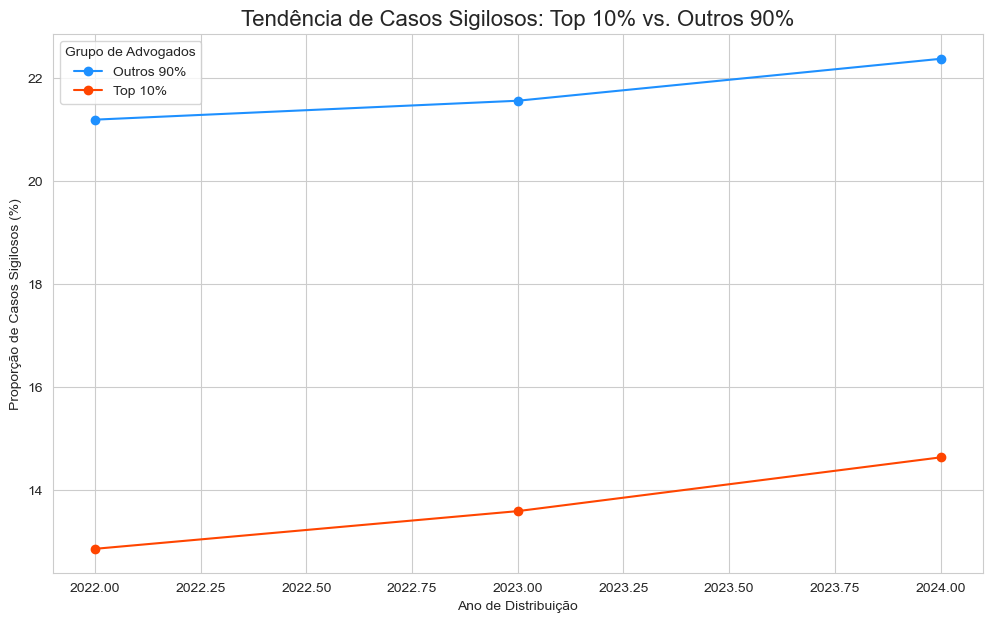

In [18]:
# 3. Visualiza√ß√£o Gr√°fica
print("\n" + "="*100)
print("=== COMPARA√á√ÉO DOS RESULTADOS ===")
print("="*100 + "\n")

plt.figure(figsize=(12, 7))

# 3.1 Obter os nomes dos grupos √∫nicos para o loop
grupos = analise_grupo_anual['grupo_advogado'].unique()

# (Opcional) Definir cores para cada grupo para um visual mais controlado
cores = {'Top 10%': 'orangered', 'Outros 90%': 'dodgerblue'}

# 3.2 Loop para plotar uma linha para cada grupo
for grupo in grupos:
    # Filtrar o DataFrame para conter apenas os dados do grupo atual
    dados_do_grupo = analise_grupo_anual[analise_grupo_anual['grupo_advogado'] == grupo]
    
    # Plotar a linha para este grupo espec√≠fico
    plt.plot(
        dados_do_grupo['ano_distribuicao'],
        dados_do_grupo['proporcao_sigilosos_%'],
        marker='o',
        linestyle='-',
        label=grupo,
        color=cores.get(grupo)
    )

# 3.3 Gr√°fico
plt.title('Tend√™ncia de Casos Sigilosos: Top 10% vs. Outros 90%', fontsize=16)
plt.xlabel('Ano de Distribui√ß√£o')
plt.ylabel('Propor√ß√£o de Casos Sigilosos (%)')
plt.legend(title='Grupo de Advogados')
plt.grid(True)
plt.show()

## üí° An√°lise Estrat√©gica: Tend√™ncias de Atua√ß√£o em Casos Sigilosos

---

### ü•á Conclus√£o Principal: A Surpreendente Especializa√ß√£o dos Advogados de Menor Volume

A descoberta mais importante e inesperada √© que o grupo **"Outros 90%"** (advogados com menor volume total de processos) possui uma propor√ß√£o consistentemente maior de casos sigilosos.

* **Evid√™ncia:** A linha azul ("Outros 90%") est√° o tempo todo significativamente acima da linha laranja ("Top 10%"). Em 2024, por exemplo, mais de 22% do portf√≥lio do advogado "comum" era de casos sigilosos, contra menos de 15% para o advogado de alto volume.
* **Interpreta√ß√£o:** Isso refuta a hip√≥tese de que os advogados "Top 10%" dominam todas as √°reas. Pelo contr√°rio, sugere que o alto volume deles √© massivamente concentrado em casos n√£o sigilosos. A atua√ß√£o em casos sigilosos parece ser uma √°rea de maior foco ou especializa√ß√£o para os advogados que n√£o comp√µem o alto volume.

---

### üìà Conclus√£o 2: A Tend√™ncia de Crescimento √© Universal

Apesar da diferen√ßa nos n√≠veis, ambas as linhas mostram uma clara e inquestion√°vel tend√™ncia de alta.

* **Evid√™ncia:** Tanto a linha azul quanto a laranja sobem de forma consistente de 2022 a 2024.
* **Interpreta√ß√£o:** O aumento na relev√¢ncia dos processos sigilosos n√£o √© um fen√¥meno isolado de um grupo, mas sim um **movimento geral do mercado**. Todos os perfis de advogados, tanto os de alto volume quanto os demais, est√£o vendo uma participa√ß√£o crescente de casos sigilosos em sua carga de trabalho.

---

### üöÄ Conclus√£o 3: A Ado√ß√£o de Casos Sigilosos est√° Acelerando

O crescimento n√£o √© apenas constante, ele est√° ganhando for√ßa.

* **Evid√™ncia:** A inclina√ß√£o de ambas as linhas parece ficar mais acentuada entre 2023 e 2024.
* **Interpreta√ß√£o:** O movimento em dire√ß√£o a uma maior propor√ß√£o de casos sigilosos est√° **acelerando**, indicando que os fatores que impulsionam essa tend√™ncia (sejam legislativos, sociais ou de mercado) se tornaram ainda mais fortes no √∫ltimo ano.

---

### üß† S√≠ntese Estrat√©gica Final

Respondendo √† pergunta central da sua an√°lise ("Os advogados de alto volume est√£o dominando o nicho de casos sigilosos?"):

> A resposta √© **N√ÉO**. Embora os advogados "Top 10%" tamb√©m estejam aumentando sua atua√ß√£o em casos sigilosos, essa √°rea representa uma fatia **menor** de seu portf√≥lio em compara√ß√£o com os outros 90% dos advogados. O crescimento do nicho de processos sigilosos parece estar fortalecendo a atua√ß√£o de advogados especialistas que **n√£o s√£o, necessariamente, os l√≠deres em volume total**, consolidando essa √°rea como um campo de especializa√ß√£o distinto no mercado.

### **‚ùì PERGUNTA 4:** Qual a efici√™ncia de baixa dos Processos Sigilosos e dos Processos N√£o Sigilosos?

In [19]:
# ) An√°lise de Processos Baixados
# Usar uma c√≥pia para manter o original intacto.
df_analise_baixa = df_juridico.copy()

print("\n" + "="*100)
print("=== AN√ÅLISE DE EFICI√äNCIA DE BAIXA (PROCESSOS SIGILOSOS VS. N√ÉO SIGILOSOS) ===")
print("="*100 + "\n")

# Prepara√ß√£o dos Dados
# -------------------------
# A coluna 'data_baixa' √© a chave. Se ela n√£o for nula, o processo foi baixado.
# Garantir que os tipos de dados estejam corretos.
df_analise_baixa['is_segredo_justica'] = df_analise_baixa['is_segredo_justica'].astype(bool)

# Criar uma coluna booleana 'processo_baixado' para facilitar os c√°lculos.
# .notna() retorna True para qualquer valor que n√£o seja nulo (ou seja, tem uma data de baixa).
df_analise_baixa['processo_baixado'] = df_analise_baixa['data_baixa'].notna()


# Segmenta√ß√£o dos Dados
# -------------------------
# Separar o DataFrame em dois: um para processos sigilosos e outro para n√£o sigilosos.
df_sigilosos = df_analise_baixa[df_analise_baixa['is_segredo_justica'] == True]
df_nao_sigilosos = df_analise_baixa[df_analise_baixa['is_segredo_justica'] == False]


# An√°lise de Processos N√ÉO SIGILOSOS
# ---------------------------------------
print("--- An√°lise de Processos N√ÉO SIGILOSOS ---")

total_nao_sigilosos = len(df_nao_sigilosos)
baixados_nao_sigilosos = df_nao_sigilosos['processo_baixado'].sum() # .sum() em booleanos conta os 'True'

if total_nao_sigilosos > 0:
    percentual_nao_sigilosos = (baixados_nao_sigilosos / total_nao_sigilosos) * 100
    print(f"Total de processos n√£o sigilosos: {total_nao_sigilosos}")
    print(f"Processos baixados (conclu√≠dos):   {baixados_nao_sigilosos}")
    print(f"Taxa de Baixa / Efici√™ncia:      {percentual_nao_sigilosos:.2f}%")
else:
    percentual_nao_sigilosos = 0
    print("N√£o foram encontrados processos n√£o sigilosos na base de dados.")


# An√°lise de Processos SIGILOSOS
# -----------------------------------
print("\n--- An√°lise de Processos SIGILOSOS ---")

total_sigilosos = len(df_sigilosos)
baixados_sigilosos = df_sigilosos['processo_baixado'].sum()

if total_sigilosos > 0:
    percentual_sigilosos = (baixados_sigilosos / total_sigilosos) * 100
    print(f"Total de processos sigilosos: {total_sigilosos}")
    print(f"Processos baixados (conclu√≠dos): {baixados_sigilosos}")
    print(f"Taxa de Baixa / Efici√™ncia:     {percentual_sigilosos:.2f}%")
else:
    percentual_sigilosos = 0
    print("N√£o foram encontrados processos sigilosos na base de dados.")


# An√°lise de Efici√™ncia Global (Contribui√ß√£o para o Total)
# -------------------------------------------------------------
print("\n--- An√°lise de Efici√™ncia Global (Contribui√ß√£o para o Total Geral) ---")

# O denominador agora √© a soma de TODOS os processos, sigilosos ou n√£o.
total_geral_processos = total_nao_sigilosos + total_sigilosos
print(f"Total geral de processos na base: {total_geral_processos}")

if total_geral_processos > 0:
    # C√°lculo: baixados n√£o sigilosos / (total sigilosos + total n√£o sigilosos)
    contrib_global_nao_sigilosos = (baixados_nao_sigilosos / total_geral_processos) * 100
    print(f"Contribui√ß√£o dos baixados N√ÉO SIGILOSOS para o total: {contrib_global_nao_sigilosos:.2f}%")

    # C√°lculo: baixados sigilosos / (total sigilosos + total n√£o sigilosos)
    contrib_global_sigilosos = (baixados_sigilosos / total_geral_processos) * 100
    print(f"Contribui√ß√£o dos baixados SIGILOSOS para o total:    {contrib_global_sigilosos:.2f}%")
else:
    print("N√£o h√° processos para calcular a efici√™ncia global.")


# Conclus√£o e Interpreta√ß√£o
# ------------------------------
print("\n" + "-"*50)
print("--- Conclus√£o da An√°lise ---")

if total_nao_sigilosos > 0 and total_sigilosos > 0:
    if abs(percentual_sigilosos - percentual_nao_sigilosos) < 1.0: # Diferen√ßa menor que 1%
        print("As taxas de baixa para processos sigilosos e n√£o sigilosos s√£o muito semelhantes.")
        print("Isso sugere que a natureza do processo (sigiloso ou n√£o) tem pouco impacto na sua velocidade de conclus√£o.")
    elif percentual_sigilosos > percentual_nao_sigilosos:
        diferenca = percentual_sigilosos - percentual_nao_sigilosos
        print(f"A taxa de baixa para processos SIGILOSOS √© {diferenca:.2f} pontos percentuais MAIOR.")
        print("Isso pode indicar que casos sigilosos, talvez por sua natureza (ex: acordos em direito de fam√≠lia), chegam a uma resolu√ß√£o mais rapidamente.")
        print("Um advogado poderia interpretar isso como uma √°rea de atua√ß√£o com um 'giro' mais r√°pido de casos.")
    else:
        diferenca = percentual_nao_sigilosos - percentual_sigilosos
        print(f"A taxa de baixa para processos N√ÉO SIGILOSOS √© {diferenca:.2f} pontos percentuais MAIOR.")
        print("Isso pode sugerir que processos p√∫blicos, talvez por serem mais padronizados, tramitam de forma mais eficiente no sistema judici√°rio.")
        print("Para um advogado, isso pode significar um retorno financeiro potencialmente mais previs√≠vel em volume.")
else:
    print("N√£o foi poss√≠vel realizar uma compara√ß√£o por falta de dados em uma das categorias.")



=== AN√ÅLISE DE EFICI√äNCIA DE BAIXA (PROCESSOS SIGILOSOS VS. N√ÉO SIGILOSOS) ===

--- An√°lise de Processos N√ÉO SIGILOSOS ---
Total de processos n√£o sigilosos: 4189374
Processos baixados (conclu√≠dos):   2674975
Taxa de Baixa / Efici√™ncia:      63.85%

--- An√°lise de Processos SIGILOSOS ---
Total de processos sigilosos: 754977
Processos baixados (conclu√≠dos): 520138
Taxa de Baixa / Efici√™ncia:     68.89%

--- An√°lise de Efici√™ncia Global (Contribui√ß√£o para o Total Geral) ---
Total geral de processos na base: 4944351
Contribui√ß√£o dos baixados N√ÉO SIGILOSOS para o total: 54.10%
Contribui√ß√£o dos baixados SIGILOSOS para o total:    10.52%

--------------------------------------------------
--- Conclus√£o da An√°lise ---
A taxa de baixa para processos SIGILOSOS √© 5.04 pontos percentuais MAIOR.
Isso pode indicar que casos sigilosos, talvez por sua natureza (ex: acordos em direito de fam√≠lia), chegam a uma resolu√ß√£o mais rapidamente.
Um advogado poderia interpretar isso c

## üìä An√°lise de Efici√™ncia de Baixa de Processos

A an√°lise compara a "velocidade" de conclus√£o (taxa de baixa) entre processos sigilosos e n√£o sigilosos, revelando qual categoria chega a uma resolu√ß√£o de forma mais eficiente e qual contribui mais para o volume geral de casos conclu√≠dos.

---

### üìñ Processos N√£o Sigilosos

* **Total de Processos:** 4.189.374
* **Processos Baixados (Conclu√≠dos):** 2.674.975
* **Taxa de Baixa / Efici√™ncia Interna:** `63.85%`

---

### üîí Processos Sigilosos

* **Total de Processos:** 754.977
* **Processos Baixados (Conclu√≠dos):** 520.138
* **Taxa de Baixa / Efici√™ncia Interna:** `68.89%`

---

### üåç Contribui√ß√£o para o Total Geral

Esta m√©trica mostra o impacto do volume de cada categoria no universo total de processos.

* **Contribui√ß√£o dos baixados N√ÉO SIGILOSOS:** `54.10%`
* **Contribui√ß√£o dos baixados SIGILOSOS:** `10.52%`

*Apesar da menor taxa de efici√™ncia interna, o volume massivo de processos n√£o sigilosos faz com que eles representem a maior parte de todos os casos conclu√≠dos.*

---

### üéØ Veredito da An√°lise

> A taxa de baixa para processos **SIGILOSOS √© 5.04 pontos percentuais MAIOR**.
>
> Isso pode indicar que casos sigilosos, talvez por sua natureza (ex: acordos em direito de fam√≠lia), chegam a uma resolu√ß√£o mais rapidamente. Um advogado poderia interpretar isso como uma √°rea de atua√ß√£o com um 'giro' mais r√°pido de casos.


=== ü§ñ INICIANDO APLICA√á√ÉO DE MACHINE LEARNING ===
=== Modelo: Previs√£o de Tempo de Resolu√ß√£o de Processos ===

Total de registros inicial: 4944351
Total de registros com data de baixa (usados para treino/teste): 3195113


Categorizando Dura√ß√£o:   0%|          | 0/3195113 [00:00<?, ?it/s]


--- Distribui√ß√£o da vari√°vel alvo ---
categoria_duracao
Curto Prazo (< 1 ano)     63.807759
M√©dio Prazo (1-3 anos)    35.346856
Longo Prazo (> 3 anos)     0.845385
Name: proportion, dtype: float64


C:\Users\jcpsrodrigues\AppData\Local\Temp\ipykernel_9240\1558906957.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_ml['total_processos'].fillna(df_ml['total_processos'].median(), inplace=True)
C:\Users\jcpsrodrigues\AppData\Local\Temp\ipykernel_9240\1558906957.py:68: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are s


--- Iniciando pr√©-processamento e treinamento do modelo ---
Tamanho do conjunto de treino: 2556090 registros
Tamanho do conjunto de teste:  639023 registros


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 14.3min finished



‚úÖ Modelo treinado com sucesso!

=== üìä AVALIA√á√ÉO DE PERFORMANCE DO MODELO ===



[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    3.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    9.5s finished


Acur√°cia do modelo no conjunto de teste: 0.75%

--- Relat√≥rio de Classifica√ß√£o Detalhado ---
                        precision    recall  f1-score   support

 Curto Prazo (< 1 ano)       0.85      0.80      0.83    407746
Longo Prazo (> 3 anos)       0.08      0.49      0.14      5402
M√©dio Prazo (1-3 anos)       0.67      0.65      0.66    225875

              accuracy                           0.75    639023
             macro avg       0.53      0.65      0.54    639023
          weighted avg       0.78      0.75      0.76    639023


--- Matriz de Confus√£o ---


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.3s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    8.8s finished


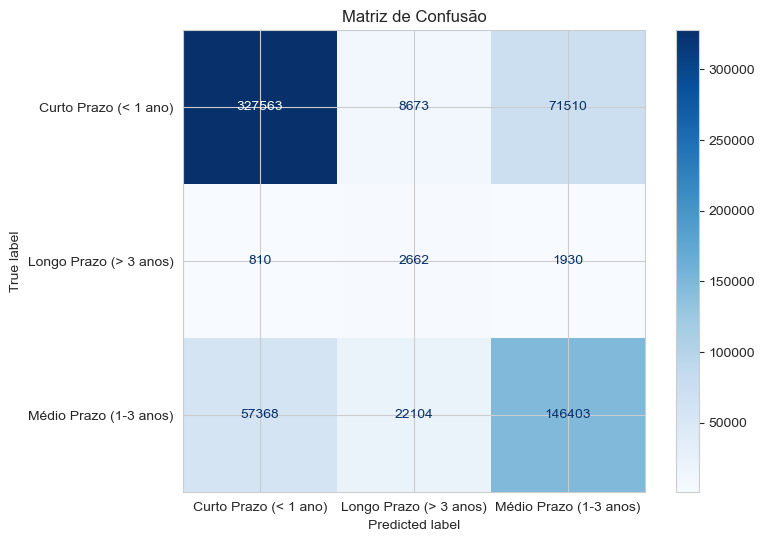


=== üí° AN√ÅLISE DE IMPORT√ÇNCIA DOS ATRIBUTOS (FEATURES) ===



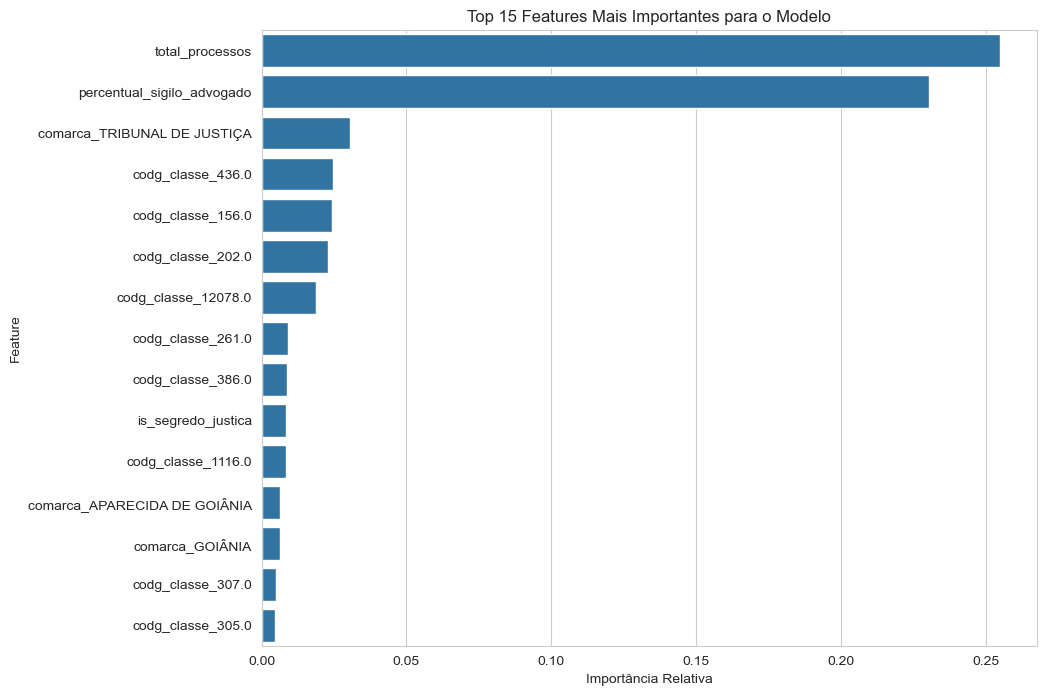

In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# ==============================================================================
# --- PARTE 1: PREPARA√á√ÉO E ENGENHARIA DE ATRIBUTOS (FEATURE ENGINEERING) ---
# ==============================================================================
print("\n" + "="*100)
print("=== ü§ñ INICIANDO APLICA√á√ÉO DE MACHINE LEARNING ===")
print("=== Modelo: Previs√£o de Tempo de Resolu√ß√£o de Processos ===")
print("="*100 + "\n")

# Usamos uma c√≥pia do DataFrame original para o projeto de ML
df_ml = df_juridico.copy()

# --- 1.1: Filtrar apenas processos j√° conclu√≠dos ---
# O modelo s√≥ pode ser treinado com dados que j√° t√™m um resultado (data_baixa).
print(f"Total de registros inicial: {len(df_ml)}")
df_ml = df_ml[df_ml['data_baixa'].notna()].copy()
print(f"Total de registros com data de baixa (usados para treino/teste): {len(df_ml)}")

# --- 1.2: Criar a Vari√°vel Alvo (Target) ---
# Garantir que as colunas de data est√£o no formato datetime
df_ml['data_distribuicao'] = pd.to_datetime(df_ml['data_distribuicao'], errors='coerce')
df_ml['data_baixa'] = pd.to_datetime(df_ml['data_baixa'], errors='coerce')

# Calcular a dura√ß√£o em dias
df_ml['duracao_dias'] = (df_ml['data_baixa'] - df_ml['data_distribuicao']).dt.days

# Remover quaisquer dura√ß√µes negativas ou nulas (erros de dados)
df_ml.dropna(subset=['duracao_dias'], inplace=True)
df_ml = df_ml[df_ml['duracao_dias'] >= 0]

# Fun√ß√£o para criar as categorias de tempo
def categoriza_duracao(dias):
    if dias <= 365:
        return 'Curto Prazo (< 1 ano)'
    elif 365 < dias <= 1095: # 3 anos = 1095 dias
        return 'M√©dio Prazo (1-3 anos)'
    else:
        return 'Longo Prazo (> 3 anos)'

# Barra de Progresso:
tqdm.pandas(desc="Categorizando Dura√ß√£o")

# Aplicar a fun√ß√£o para criar a coluna alvo
df_ml['categoria_duracao'] = df_ml['duracao_dias'].progress_apply(categoriza_duracao)

print("\n--- Distribui√ß√£o da vari√°vel alvo ---")
print(df_ml['categoria_duracao'].value_counts(normalize=True) * 100)


# --- 1.3: Criar Atributos do Advogado (Features do Perfil) ---
# Usamos o df_pivot_sorted da an√°lise anterior para obter as estat√≠sticas por advogado
lawyer_stats = df_pivot_sorted[['total_processos']].copy()
lawyer_stats['percentual_sigilo_advogado'] = (df_pivot_sorted['sigilosos'] / df_pivot_sorted['total_processos']) * 100
lawyer_stats.index.name = 'oab' # Renomear o √≠ndice para a jun√ß√£o

# Juntar as estat√≠sticas do advogado ao nosso DataFrame de ML
df_ml = df_ml.merge(lawyer_stats, on='oab', how='left')

# Preencher NaNs para advogados que n√£o estavam no df_pivot (caso existam)
df_ml['total_processos'].fillna(df_ml['total_processos'].median(), inplace=True)
df_ml['percentual_sigilo_advogado'].fillna(0, inplace=True)


# --- 1.4: Sele√ß√£o e Limpeza Final das Features ---
# Selecionar as colunas que ser√£o usadas como "pistas" para o modelo
features = [
    'comarca', 
    'serventia', 
    'codg_classe', 
    'is_segredo_justica',
    'total_processos', # Feature que criamos
    'percentual_sigilo_advogado' # Feature que criamos
]
target = 'categoria_duracao'

# Preencher valores nulos nas features categ√≥ricas
for col in ['comarca', 'serventia', 'codg_classe']:
    df_ml[col].fillna('Desconhecido', inplace=True)

df_ml['is_segredo_justica'] = df_ml['is_segredo_justica'].astype(bool)

# ==============================================================================
# --- PARTE 2: PR√â-PROCESSAMENTO E TREINAMENTO DO MODELO ---
# ==============================================================================
print("\n--- Iniciando pr√©-processamento e treinamento do modelo ---")

# --- 2.1: One-Hot Encoding das vari√°veis categ√≥ricas ---
# O modelo precisa de n√∫meros, n√£o de texto. pd.get_dummies faz a convers√£o.
X = pd.get_dummies(df_ml[features], drop_first=True, dummy_na=False)
y = df_ml[target]

# --- 2.2: Divis√£o em Treino e Teste ---
# Separamos os dados para treinar o modelo e para test√°-lo em dados "nunca vistos"
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Tamanho do conjunto de treino: {X_train.shape[0]} registros")
print(f"Tamanho do conjunto de teste:  {X_test.shape[0]} registros")


# --- 2.3: Treinamento do Modelo RandomForest ---
# Escolhemos o RandomForest por ser robusto e bom com dados tabulares
model = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, n_jobs=-1, 
    class_weight='balanced',
    verbose=1
)

model.fit(X_train, y_train)
print("\n‚úÖ Modelo treinado com sucesso!")

# ==============================================================================
# --- PARTE 3: AVALIA√á√ÉO DE PERFORMANCE ---
# ==============================================================================
print("\n" + "="*100)
print("=== üìä AVALIA√á√ÉO DE PERFORMANCE DO MODELO ===")
print("="*100 + "\n")

# Fazer previs√µes no conjunto de teste
y_pred = model.predict(X_test)

# --- 3.1: M√©tricas de Classifica√ß√£o ---
accuracy = accuracy_score(y_test, y_pred)
print(f"Acur√°cia do modelo no conjunto de teste: {accuracy:.2f}%")
print("\n--- Relat√≥rio de Classifica√ß√£o Detalhado ---")
print(classification_report(y_test, y_pred))


# --- 3.2: Matriz de Confus√£o ---
# Mostra visualmente onde o modelo est√° acertando e errando
print("\n--- Matriz de Confus√£o ---")
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=ax, cmap='Blues')
plt.title('Matriz de Confus√£o')
plt.show()

# ==============================================================================
# --- PARTE 4: AN√ÅLISE DE IMPORT√ÇNCIA DAS FEATURES ---
# ==============================================================================
print("\n" + "="*100)
print("=== üí° AN√ÅLISE DE IMPORT√ÇNCIA DOS ATRIBUTOS (FEATURES) ===")
print("="*100 + "\n")

# Extrair a import√¢ncia de cada feature
importances = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotar as features mais importantes
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15)) # Top 15 features
plt.title('Top 15 Features Mais Importantes para o Modelo')
plt.xlabel('Import√¢ncia Relativa')
plt.ylabel('Feature')
plt.show()

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Modelos
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

# M√©tricas
from sklearn.metrics import accuracy_score, classification_report, f1_score

# --- PARTE 1: PREPARA√á√ÉO DOS DADOS (Id√™ntica √† anterior) ---
# Esta se√ß√£o √© a mesma do script anterior e est√° aqui para garantir a execu√ß√£o.

print("\n" + "="*100)
print("=== ü§ñ INICIANDO COMPARA√á√ÉO DE MODELOS DE MACHINE LEARNING ===")
print("="*100 + "\n")

df_ml = df_juridico.copy()

# Filtrar, criar alvo e features...
df_ml = df_ml[df_ml['data_baixa'].notna()].copy()
df_ml['data_distribuicao'] = pd.to_datetime(df_ml['data_distribuicao'], errors='coerce')
df_ml['data_baixa'] = pd.to_datetime(df_ml['data_baixa'], errors='coerce')
df_ml['duracao_dias'] = (df_ml['data_baixa'] - df_ml['data_distribuicao']).dt.days
df_ml.dropna(subset=['duracao_dias'], inplace=True)
df_ml = df_ml[df_ml['duracao_dias'] >= 0]

def categoriza_duracao(dias):
    if dias <= 365: return 'Curto Prazo (< 1 ano)'
    elif 365 < dias <= 1095: return 'M√©dio Prazo (1-3 anos)'
    else: return 'Longo Prazo (> 3 anos)'

df_ml['categoria_duracao'] = df_ml['duracao_dias'].apply(categoriza_duracao)

lawyer_stats = df_pivot_sorted[['total_processos']].copy()
lawyer_stats['percentual_sigilo_advogado'] = (df_pivot_sorted['sigilosos'] / df_pivot_sorted['total_processos']) * 100
lawyer_stats.index.name = 'oab'
df_ml = df_ml.merge(lawyer_stats, on='oab', how='left')
df_ml['total_processos'].fillna(df_ml['total_processos'].median(), inplace=True)
df_ml['percentual_sigilo_advogado'].fillna(0, inplace=True)

features = ['comarca', 'serventia', 'codg_classe', 'is_segredo_justica', 'total_processos', 'percentual_sigilo_advogado']
target = 'categoria_duracao'
for col in ['comarca', 'serventia', 'codg_classe']:
    df_ml[col].fillna('Desconhecido', inplace=True)
df_ml['is_segredo_justica'] = df_ml['is_segredo_justica'].astype(bool)

X = pd.get_dummies(df_ml[features], drop_first=True, dummy_na=False)
y = df_ml[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# --- PARTE 2: TREINAMENTO E AVALIA√á√ÉO COMPARATIVA ---

# Dicion√°rio com os modelos que vamos treinar
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced'),
    "XGBoost": xgb.XGBClassifier(random_state=42, n_jobs=-1, use_label_encoder=False, eval_metric='mlogloss'),
    "LightGBM": lgb.LGBMClassifier(random_state=42, n_jobs=-1, class_weight='balanced')
}

# Dicion√°rio para armazenar os resultados para a compara√ß√£o final
results = {}

# Loop para treinar e avaliar cada modelo
for model_name, model in models.items():
    print("\n" + "-"*50)
    print(f"--- üèãÔ∏è Treinando e Avaliando: {model_name} ---")
    
    # Treinar o modelo
    model.fit(X_train, y_train)
    
    # Fazer previs√µes
    y_pred = model.predict(X_test)
    
    # Imprimir o relat√≥rio de classifica√ß√£o
    print("\nRelat√≥rio de Classifica√ß√£o:")
    print(classification_report(y_test, y_pred))
    
    # Guardar as m√©tricas principais para a tabela de compara√ß√£o
    # Usaremos o 'f1-score' ponderado (weighted avg) que √© uma boa m√©trica geral
    results[model_name] = {
        "Acur√°cia": accuracy_score(y_test, y_pred),
        "F1-Score Ponderado": f1_score(y_test, y_pred, average='weighted')
    }

# --- PARTE 3: COMPARA√á√ÉO FINAL DOS MODELOS ---

print("\n" + "="*100)
print("=== üèÜ TABELA COMPARATIVA DE PERFORMANCE DOS MODELOS ===")
print("="*100 + "\n")

# Criar um DataFrame com os resultados
df_results = pd.DataFrame(results).T # .T transp√µe a matriz para melhor visualiza√ß√£o
df_results = df_results.sort_values(by='F1-Score Ponderado', ascending=False)

# Formatar para exibi√ß√£o
df_results['Acur√°cia'] = df_results['Acur√°cia'].map('{:.2%}'.format)
df_results['F1-Score Ponderado'] = df_results['F1-Score Ponderado'].map('{:.2%}'.format)

print(df_results)

AttributeError: module 'pandas.core.strings' has no attribute 'StringMethods'